##Part 1

 IMPORT

In [198]:
# ========== 1) IMPORT REQUIRED LIBRARIES ==========
import warnings
warnings.filterwarnings("ignore")

import yfinance as yf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Statsmodels (for ADF, decomposition, ACF/PACF)
from statsmodels.tsa.stattools import adfuller
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.seasonal import seasonal_decompose

In [199]:
"""
===========================================================
  BITCOIN DATA LOADING & EXPLORATORY ANALYSIS PIPELINE
===========================================================
This script:
1) Fetch Bitcoin (BTC-USD) data from Yahoo Finance via yfinance.
2) Resample the data to a weekly frequency.
3) Explore the data (basic stats, missing values, rolling mean plot).
4) Test for stationarity (Augmented Dickey-Fuller test).
5) Perform (seasonal) differencing.
6) Decompose the time series.
7) Plot ACF and PACF to help guide model selection.

"""



# ========== 2) HELPER FUNCTIONS ==========

def load_btc_data(period="10y", csv_file_weekly="btc_weekly_data.csv"):
    """
    Fetch Bitcoin data using yfinance for the specified period,
    then resample to weekly frequency (e.g., Monday close).
    The resulting DataFrame is saved as a CSV and returned.

    :param period: String representing the period to fetch from Yahoo (e.g., "10y", "5y", "max").
    :param csv_file_weekly: Path to CSV file to save weekly data.
    :return: pd.DataFrame of weekly BTC-USD prices with a 'bitcoin_price' column.
    """
    print(f"Fetching BTC-USD data from Yahoo Finance for the past {period}...")
    btc = yf.Ticker("BTC-USD")
    btc_data = btc.history(period=period)  # daily data

    # Drop any timezone information from the index
    btc_data.index = pd.to_datetime(btc_data.index).tz_localize(None)

    # Resample to weekly frequency
    # (e.g., W-MON means the last observed price on Monday of each week)
    btc_weekly = btc_data['Close'].resample('W-MON').last().dropna()

    # Rename the column for consistency
    btc_weekly = btc_weekly.to_frame(name='bitcoin_price')

    # Save to CSV
    btc_weekly.to_csv(csv_file_weekly)
    print(f"Weekly data saved to {csv_file_weekly}.")

    return btc_weekly

def explore_data(df):
    """
    Display basic information, descriptive statistics, and missing values.
    :param df: Pandas DataFrame with 'bitcoin_price'.
    """
    print("===== EXPLORING DATA =====")
    print("\n[INFO] DataFrame Info:")
    print(df.info())
    print("\n[STATS] Descriptive Statistics:")
    print(df.describe())
    print("\n[NaN] Missing Values:")
    print(df.isnull().sum())

def plot_time_series(df, title="Bitcoin Price (Weekly)", rolling_window=30):
    """
    Plot the raw Bitcoin weekly time series and overlay a rolling average.

    :param df: DataFrame containing 'bitcoin_price'.
    :param title: Title for the chart.
    :param rolling_window: Window size for the rolling mean.
    """
    plt.figure(figsize=(15, 6))
    plt.plot(df.index, df['bitcoin_price'], label='Weekly Price', color='blue', linewidth=1)

    if rolling_window > 0:
        rolling_mean = df['bitcoin_price'].rolling(window=rolling_window).mean()
        plt.plot(df.index, rolling_mean, label=f'{rolling_window}-Week Rolling Mean', color='orange', linewidth=2)

    plt.title(title, fontsize=16)
    plt.xlabel("Date", fontsize=12)
    plt.ylabel("Bitcoin Price (USD)", fontsize=12)
    plt.legend(fontsize=10)
    plt.grid(alpha=0.3)
    plt.show()

def adf_test(series, label="Series"):
    """
    Perform the Augmented Dickey-Fuller test to check stationarity.

    :param series: Pandas Series object (e.g., df['bitcoin_price']).
    :param label: String label for printing results.
    """
    print(f"\n===== ADF TEST FOR {label} =====")
    result = adfuller(series, autolag='AIC')
    print(f"ADF Statistic: {result[0]:.4f}")
    print(f"P-Value: {result[1]:.4f}")
    print("Critical Values:")
    for key, value in result[4].items():
        print(f"  {key}: {value:.4f}")

    if result[1] < 0.05:
        print(f" => '{label}' is likely stationary (p < 0.05).")
    else:
        print(f" => '{label}' is likely non-stationary (p >= 0.05).")

def decompose_series(df, model='additive', period=52):
    """
    Decompose the time series into trend, seasonality, and residuals.

    :param df: DataFrame containing 'bitcoin_price'.
    :param model: 'additive' or 'multiplicative'.
    :param period: Seasonal period (52 for weekly data to capture yearly seasonality).
    """
    print(f"\n===== DECOMPOSITION (Model={model}, Period={period}) =====")
    decomposition = seasonal_decompose(df['bitcoin_price'], model=model, period=period)
    fig = decomposition.plot()
    fig.set_size_inches(14, 9)
    fig.suptitle("Time Series Decomposition", fontsize=16)
    plt.tight_layout()
    plt.show()

from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
import matplotlib.pyplot as plt

def plot_acf_pacf(series, lags=52, title_prefix=""):
    """
    Plot ACF and PACF side by side for a given series.

    :param series: Pandas Series of values (e.g., differenced time series).
    :param lags: Number of lags to include in the plot (typically ~52 for weekly data).
    :param title_prefix: String prefix for subplot titles.
    """
    fig, axes = plt.subplots(1, 2, figsize=(15, 6))

    # ACF
    plot_acf(series, lags=lags, ax=axes[0])
    axes[0].set_title(f"{title_prefix} ACF")

    # PACF (optionally specify method='ywm' or 'yule_walker')
    plot_pacf(series, lags=lags, ax=axes[1], method='ywm')
    axes[1].set_title(f"{title_prefix} PACF")

    plt.tight_layout()
    plt.show()





In [200]:
# --- 3.1) LOAD THE DATA ---
btc_weekly = load_btc_data(period="10y", csv_file_weekly="btc_weekly_data.csv")
# --- 3.2) EXPLORE THE DATA ---
explore_data(btc_weekly)


Fetching BTC-USD data from Yahoo Finance for the past 10y...
Weekly data saved to btc_weekly_data.csv.
===== EXPLORING DATA =====

[INFO] DataFrame Info:
<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 523 entries, 2015-04-06 to 2025-04-07
Freq: W-MON
Data columns (total 1 columns):
 #   Column         Non-Null Count  Dtype  
---  ------         --------------  -----  
 0   bitcoin_price  523 non-null    float64
dtypes: float64(1)
memory usage: 8.2 KB
None

[STATS] Descriptive Statistics:
       bitcoin_price
count     523.000000
mean    22639.564282
std     24938.749584
min       210.494995
25%      3752.128784
50%     10583.134766
75%     36864.804688
max    106029.718750

[NaN] Missing Values:
bitcoin_price    0
dtype: int64


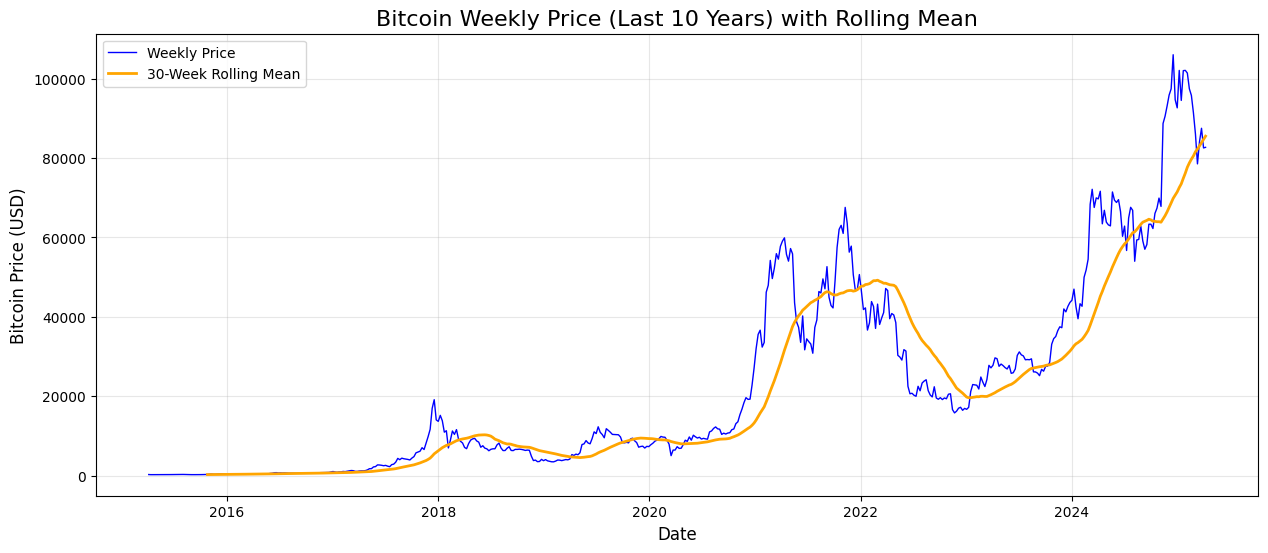


===== ADF TEST FOR Original Weekly Series =====
ADF Statistic: 0.1844
P-Value: 0.9714
Critical Values:
  1%: -3.4433
  5%: -2.8673
  10%: -2.5698
 => 'Original Weekly Series' is likely non-stationary (p >= 0.05).


In [201]:
# Plot the original time series with a rolling mean
plot_time_series(btc_weekly,
                  title="Bitcoin Weekly Price (Last 10 Years) with Rolling Mean",
                  rolling_window=30)

# --- 3.3) STATIONARITY CHECK (ADF) ON ORIGINAL SERIES ---
adf_test(btc_weekly['bitcoin_price'], label="Original Weekly Series")

 DECOMPOSE THE SERIES (WEEKLY = PERIOD 52)


===== DECOMPOSITION (Model=additive, Period=52) =====


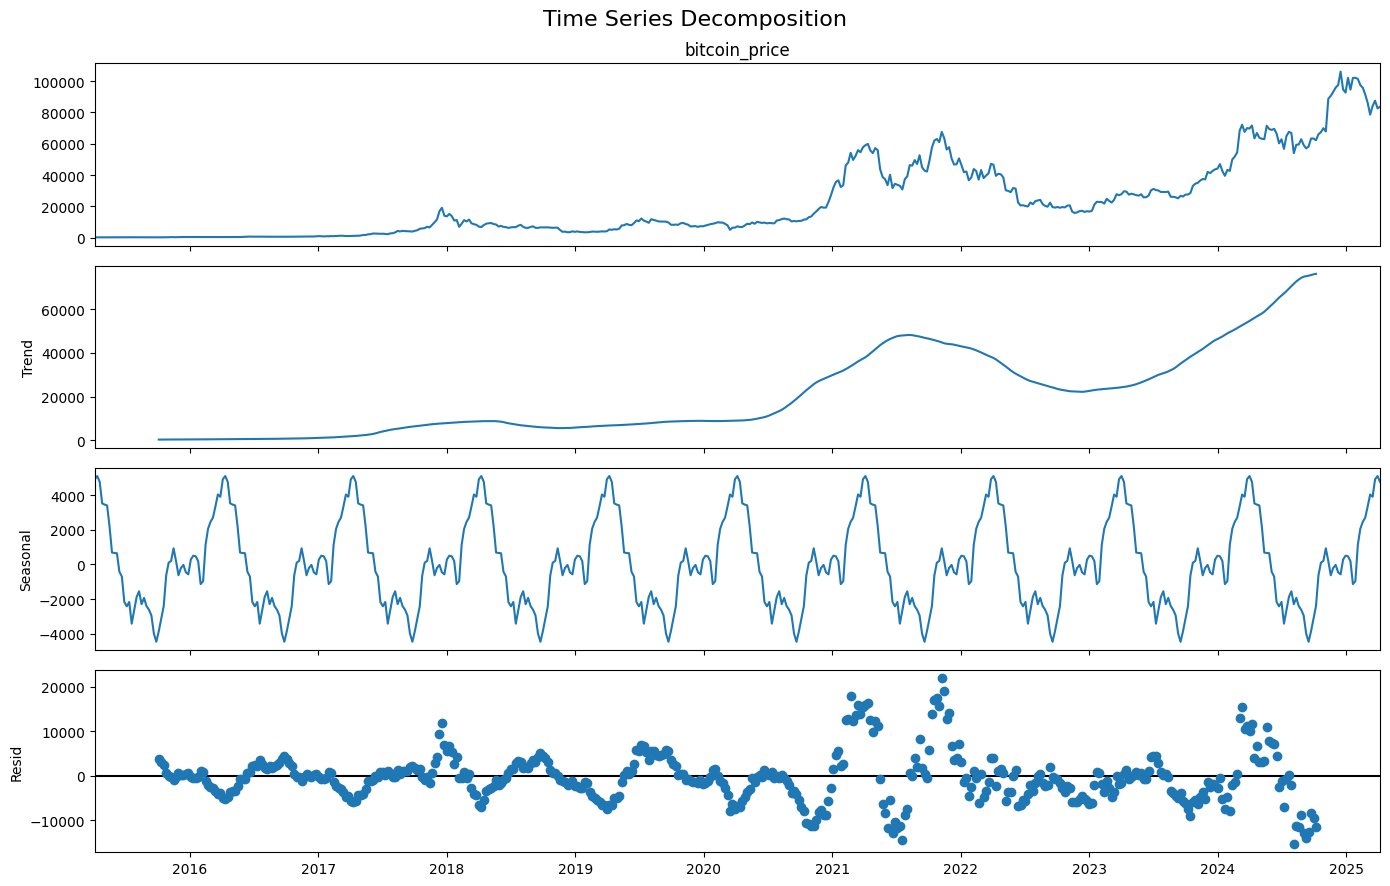

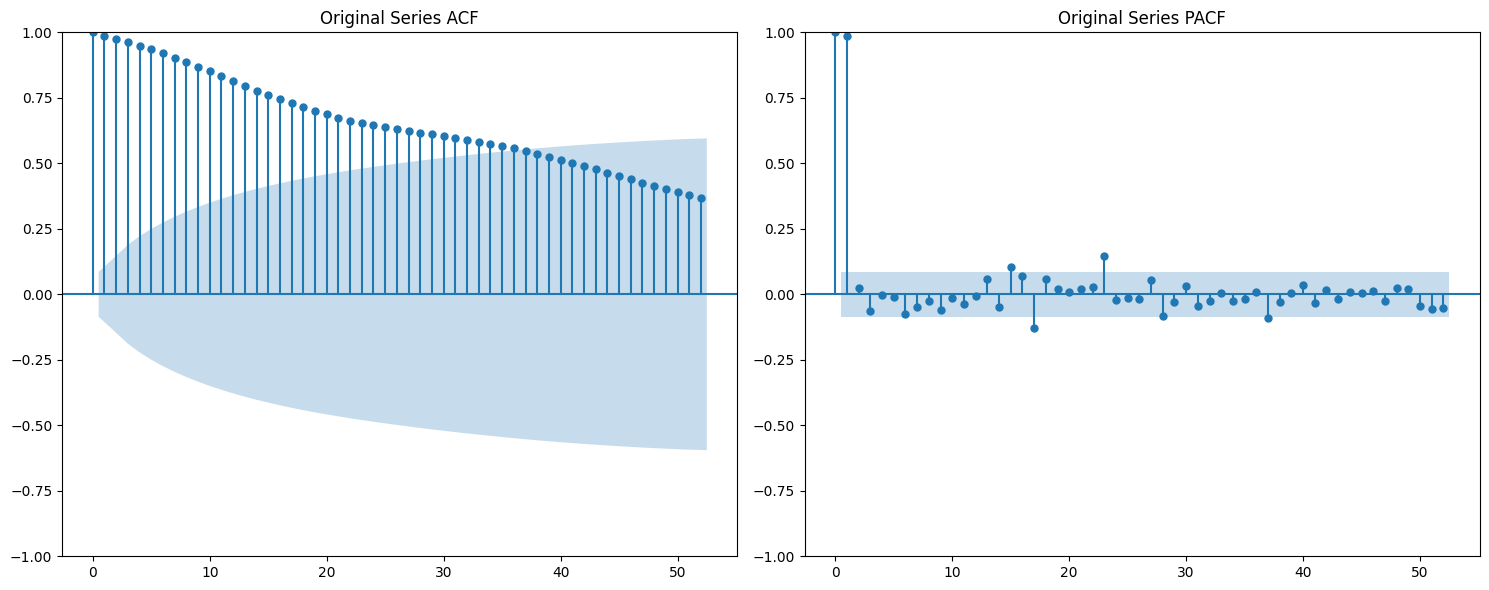

In [14]:
# --- 3.4) DECOMPOSE THE SERIES (WEEKLY = PERIOD 52) ---
decompose_series(btc_weekly, model='additive', period=52)

# --- 3.5) ACF/PACF ON ORIGINAL SERIES ---
plot_acf_pacf(btc_weekly['bitcoin_price'], lags=52, title_prefix="Original Series")

First Differencing


===== ADF TEST FOR First-Differenced Series =====
ADF Statistic: -7.2345
P-Value: 0.0000
Critical Values:
  1%: -3.4433
  5%: -2.8673
  10%: -2.5698
 => 'First-Differenced Series' is likely stationary (p < 0.05).


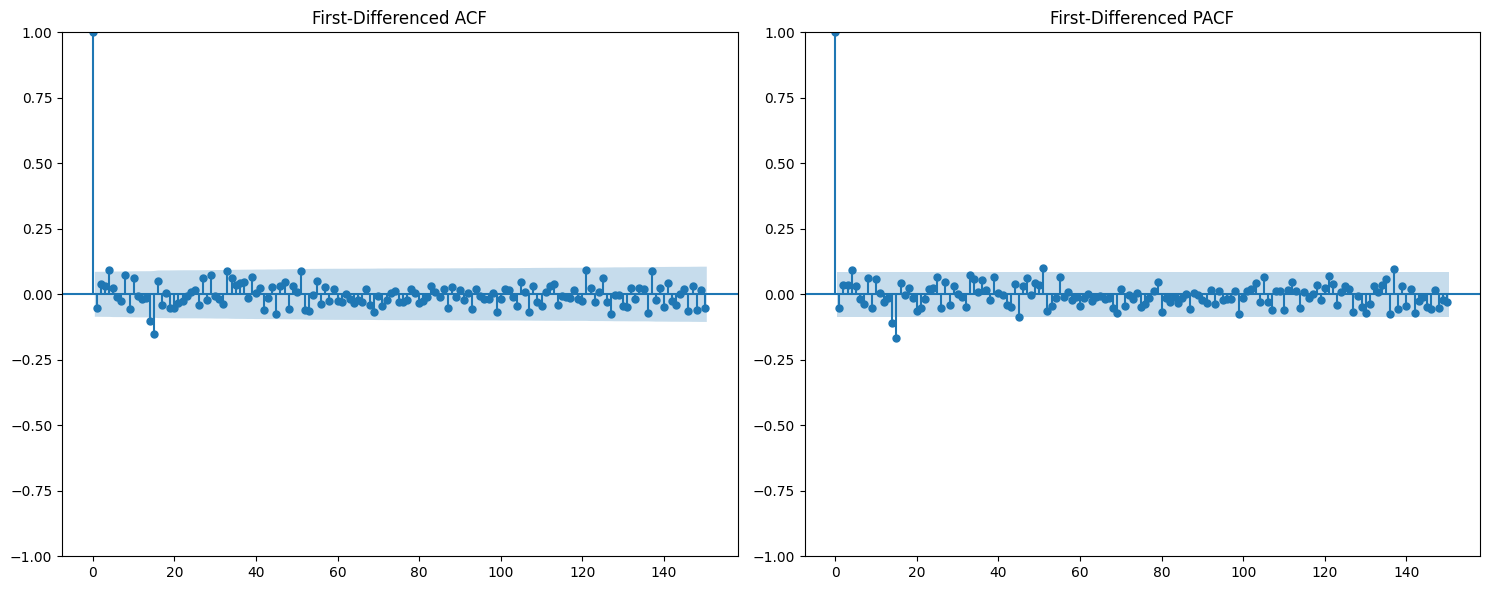

In [68]:
# --- 3.6) DIFFERENCING EXAMPLES ---
# 1) First Differencing
# first-differenced BTC series
btc_diff_1 = btc_weekly['bitcoin_price'].diff().dropna()
adf_test(btc_diff_1, label="First-Differenced Series")
plot_acf_pacf(btc_diff_1,
              lags=150,
              title_prefix="First-Differenced")



Seasonal Differencing


===== ADF TEST FOR Seasonally Differenced Series =====
ADF Statistic: -2.2277
P-Value: 0.1963
Critical Values:
  1%: -3.4448
  5%: -2.8679
  10%: -2.5702
 => 'Seasonally Differenced Series' is likely non-stationary (p >= 0.05).


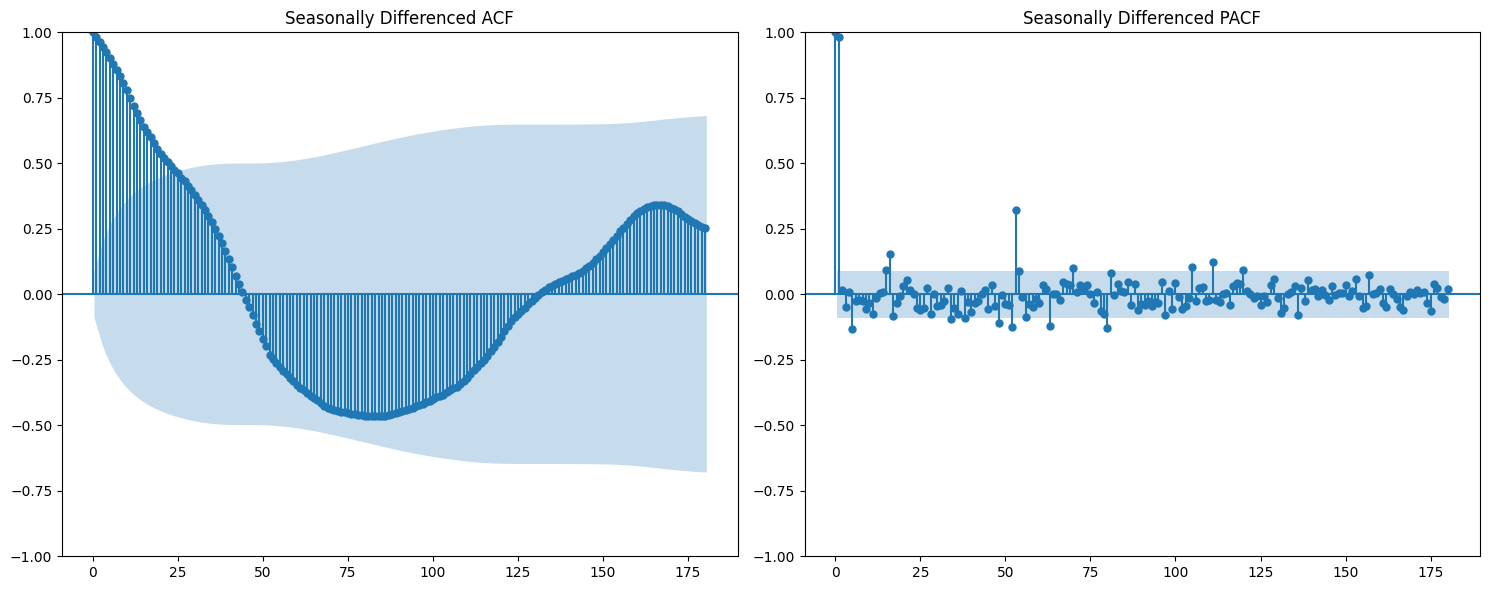

In [117]:
# 2) Seasonal Differencing (period=52 for weekly data)
btc_diff_seasonal = btc_weekly['bitcoin_price'].diff(52).dropna()
adf_test(btc_diff_seasonal, label="Seasonally Differenced Series")
plot_acf_pacf(btc_diff_seasonal, lags=180, title_prefix="Seasonally Differenced")

Combined Differencing


===== ADF TEST FOR Combined First+Seasonal Differenced Series =====
ADF Statistic: -6.3262
P-Value: 0.0000
Critical Values:
  1%: -3.4448
  5%: -2.8679
  10%: -2.5702
 => 'Combined First+Seasonal Differenced Series' is likely stationary (p < 0.05).


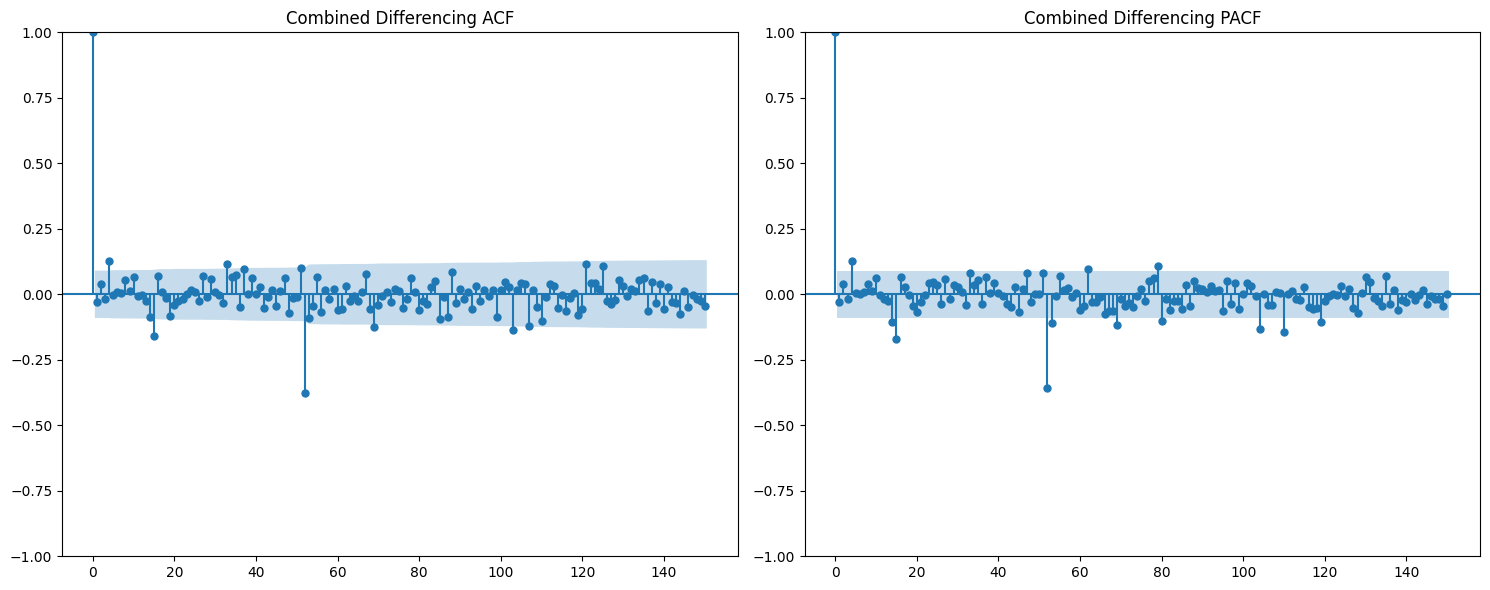

In [133]:
# 3) Combined Differencing (First + Seasonal)
#   e.g., do a first diff, then a seasonal diff
btc_diff_combined = btc_weekly['bitcoin_price'].diff().diff(52).dropna()
adf_test(btc_diff_combined, label="Combined First+Seasonal Differenced Series")
plot_acf_pacf(btc_diff_combined, lags=150, title_prefix="Combined Differencing")

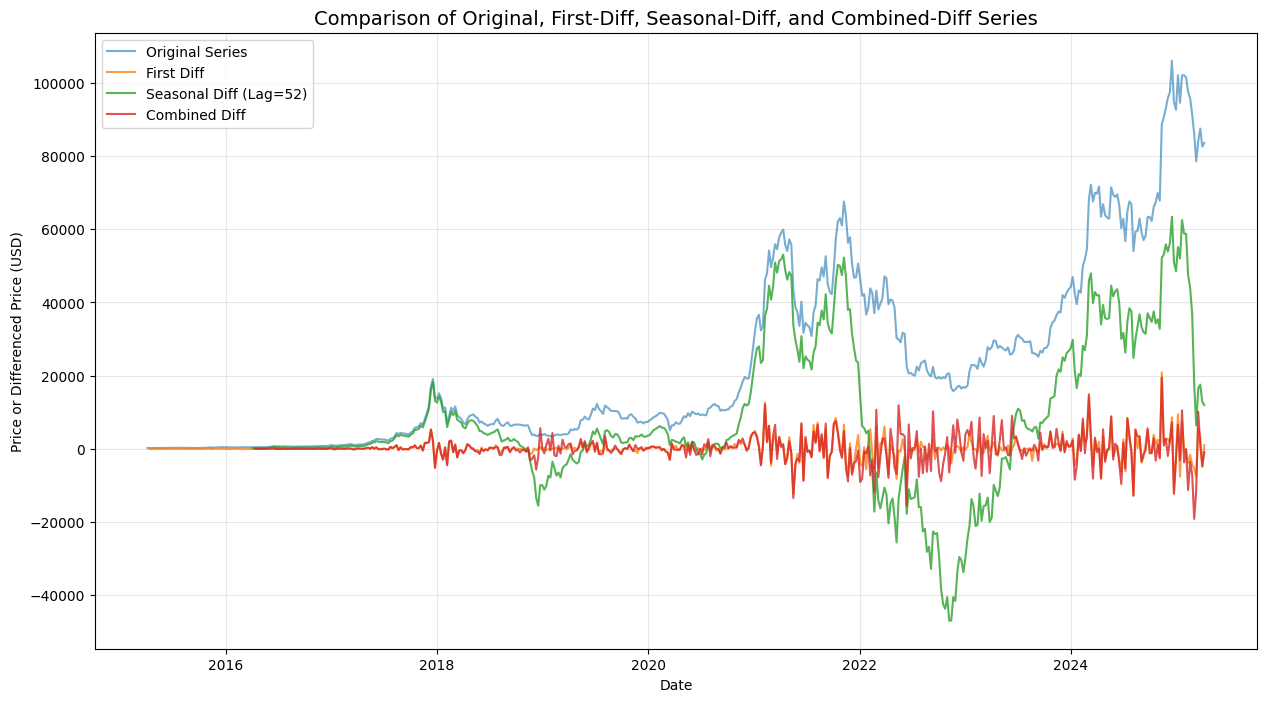


=== EXPLORATORY AND STATIONARITY ANALYSIS COMPLETE ===


In [16]:
    # --- 3.7) PLOT ALL DIFFERENT SERIES TO COMPARE ---
    plt.figure(figsize=(15, 8))
    plt.plot(btc_weekly.index, btc_weekly['bitcoin_price'], label="Original Series", alpha=0.6)
    plt.plot(btc_diff_1.index, btc_diff_1, label="First Diff", alpha=0.8)
    plt.plot(btc_diff_seasonal.index, btc_diff_seasonal, label="Seasonal Diff (Lag=52)", alpha=0.8)
    plt.plot(btc_diff_combined.index, btc_diff_combined, label="Combined Diff", alpha=0.8)
    plt.title("Comparison of Original, First-Diff, Seasonal-Diff, and Combined-Diff Series", fontsize=14)
    plt.xlabel("Date")
    plt.ylabel("Price or Differenced Price (USD)")
    plt.legend()
    plt.grid(alpha=0.3)
    plt.show()

    print("\n=== EXPLORATORY AND STATIONARITY ANALYSIS COMPLETE ===")

## Part 2 - Model Fitting

imports

In [202]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.preprocessing import MinMaxScaler

# -- For SARIMAX --
import statsmodels.api as sm
from statsmodels.tsa.statespace.sarimax import SARIMAX

# -- For Prophet --
# Note: In newer versions, the library might be "prophet" or "facebookprophet"
from prophet import Prophet

# -- For PyTorch LSTM --
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader

 LOAD & PREPARE DATA

In [203]:

# Define the fraction of the data used for training
train_ratio = 0.9  # 90% train, 10% test

# Compute split index
train_size = int(len(btc_weekly) * train_ratio)

# Split data
train_data = btc_weekly.iloc[:train_size].copy()
test_data = btc_weekly.iloc[train_size:].copy()

# Store the actual test values for later comparison
test_actual = test_data['bitcoin_price'].values
test_dates = test_data.index

# We'll also define a reference date that marks the boundary
train_end_date = train_data.index[-1]



# Convert test_actual (already unscaled) to numpy
test_actual_arr = test_actual.flatten()

## SARIMAX model

In [210]:
# ========== 4) SARIMAX MODELING ==========

# ---- 4.1) Fit SARIMAX model ----
# seasonal order: (p, d, q, seasonal_period)
# For weekly data and yearly seasonality, try seasonal_period=52
# These parameters are just an example; in practice, you'd do model selection.

sarimax_model = SARIMAX(
    train_data['bitcoin_price'],
    order=(2,1, 1),
    seasonal_order=(3,1,0, 52),
    enforce_stationarity=False,
    enforce_invertibility=False
)
sarimax_results = sarimax_model.fit()
# print(sarimax_results.summary())  # For debugging

# ---- 4.2) Forecast on test set ----
sarimax_forecast_object = sarimax_results.get_forecast(steps=len(test_data))
sarimax_forecast = sarimax_forecast_object.predicted_mean.values


#  EVALUATE PERFORMANCE METRICS

In [211]:
# Convert test_actual (already unscaled) to numpy
test_actual_arr = test_actual.flatten()

# SARIMAX
sarimax_mae = mean_absolute_error(test_actual_arr, sarimax_forecast)
sarimax_mse = mean_squared_error(test_actual_arr, sarimax_forecast)

sarimax_rmse = np.sqrt(sarimax_mse)
sarimax_mape = np.mean(np.abs((test_actual_arr - sarimax_forecast) / test_actual_arr)) * 100
print(f"SARIMAX MAE: {sarimax_mae:.2f}")
print(f"SARIMAX RMSE: {sarimax_rmse:.2f}")
print(f"SARIMAX MAPE: {sarimax_mape:.2f}%")

SARIMAX MAE: 10076.87
SARIMAX RMSE: 13237.96
SARIMAX MAPE: 12.17%


                                      SARIMAX Results                                      
Dep. Variable:                       bitcoin_price   No. Observations:                  470
Model:             SARIMAX(2, 1, 1)x(3, 1, [], 52)   Log Likelihood               -2449.737
Date:                             Sun, 06 Apr 2025   AIC                           4913.474
Time:                                     13:06:44   BIC                           4938.372
Sample:                                 04-06-2015   HQIC                          4923.484
                                      - 04-01-2024                                         
Covariance Type:                               opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.6567      0.686      0.957      0.339      -0.689       2.002
ar.L2          0.0191      

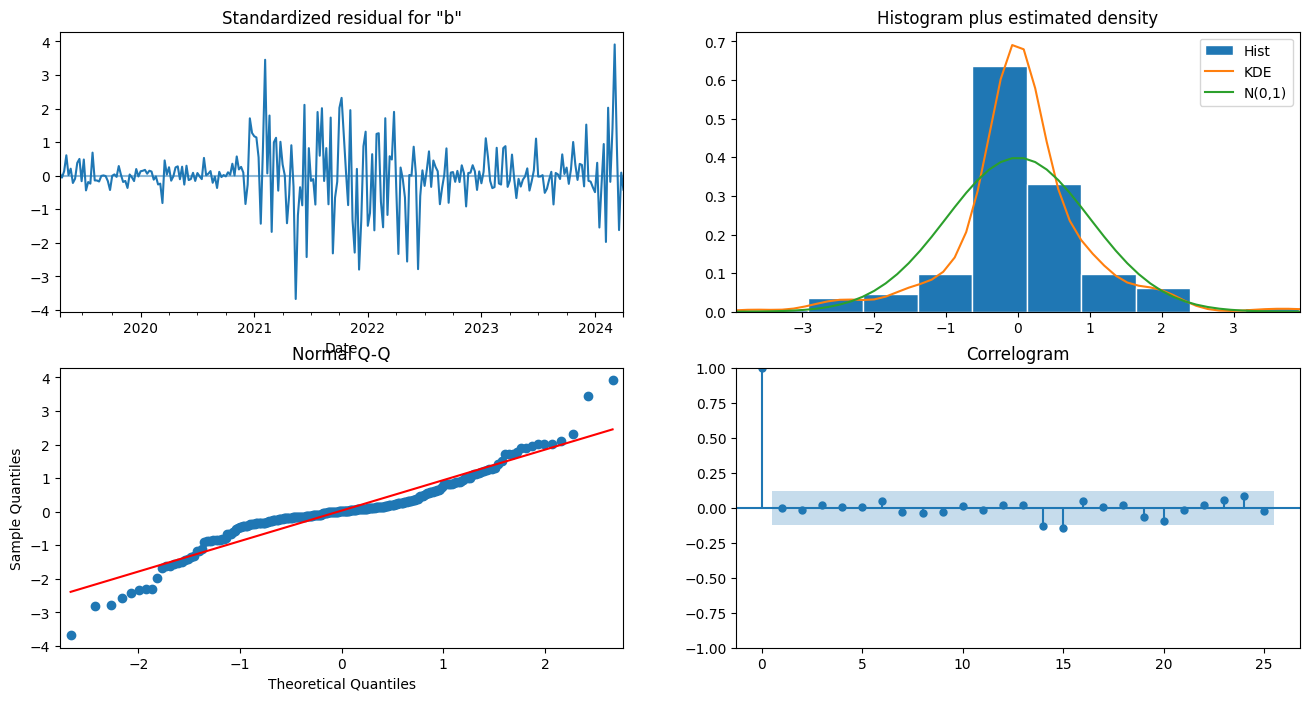

In [212]:
print(sarimax_results.summary())
fig = sarimax_results.plot_diagnostics(figsize=(16, 8), lags=25)
plt.show()

 VISUALIZATION

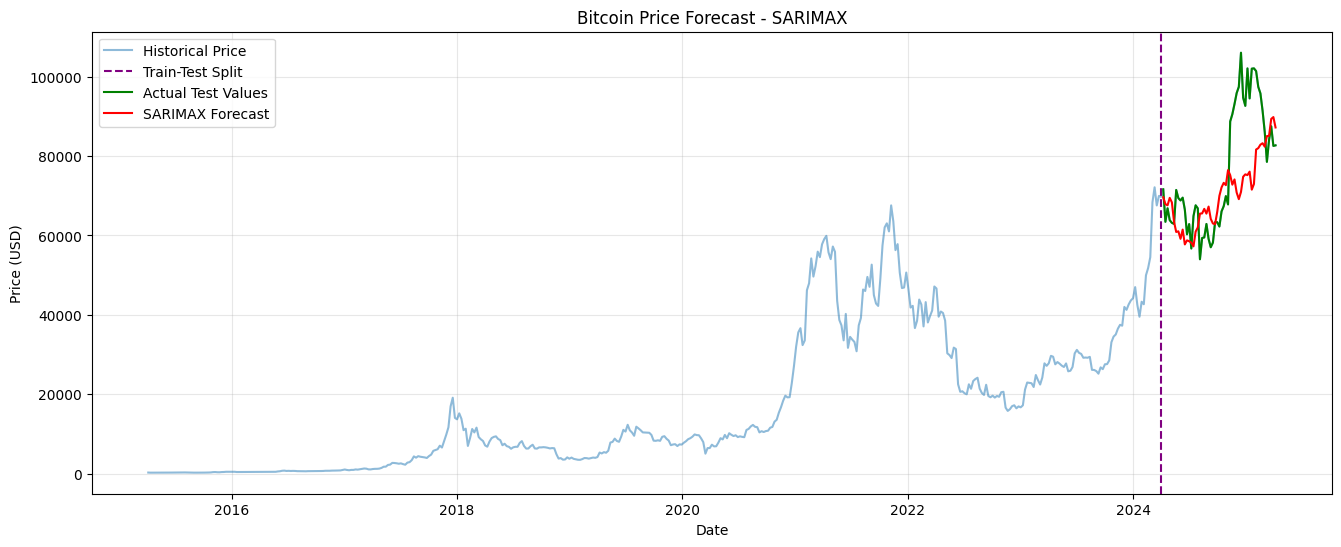

In [213]:
plt.figure(figsize=(16, 6))
plt.plot(btc_weekly.index, btc_weekly['bitcoin_price'], label='Historical Price', alpha=0.5)
plt.axvline(x=train_end_date, color='purple', linestyle='--', label='Train-Test Split')
plt.plot(test_dates, test_actual_arr, 'g-', label='Actual Test Values')
plt.plot(test_dates, sarimax_forecast, 'r-', label='SARIMAX Forecast')
plt.title("Bitcoin Price Forecast - SARIMAX")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

## Prophat model

In [121]:
def compute_rsi(series, period=14):
    delta = series.diff()
    gain = delta.where(delta > 0, 0)
    loss = -delta.where(delta < 0, 0)
    avg_gain = gain.rolling(window=period, min_periods=1).mean()
    avg_loss = loss.rolling(window=period, min_periods=1).mean()
    rs = avg_gain / (avg_loss + 1e-6)
    rsi = 100 - (100 / (1 + rs))
    return rsi


In [125]:
# # ========== 5) PROPHET MODELING ==========

# Ensure technical indicators are added to the DataFrame
train_data['ma_7'] = train_data['bitcoin_price'].rolling(window=7, min_periods=1).mean()
train_data['rsi'] = compute_rsi(train_data['bitcoin_price'])
test_data['ma_7'] = test_data['bitcoin_price'].rolling(window=7, min_periods=1).mean()
test_data['rsi'] = compute_rsi(test_data['bitcoin_price'])
# Prophet expects a DataFrame with columns 'ds', 'y' and any regressors
prophet_train = pd.DataFrame({
    'ds': train_data.index,
    'y': train_data['bitcoin_price'].values,
    'ma_7': train_data['ma_7'].values,
    'rsi': train_data['rsi'].values
})
# ---- 5.1) Fit Prophet model ----
prophet_model = Prophet(
    changepoint_prior_scale=0.2,
    changepoint_range=0.95,
    weekly_seasonality=False  # We'll add it manually
)
# Add technical indicators as external regressors
prophet_model.add_regressor('ma_7')
prophet_model.add_regressor('rsi')
# Custom seasonality (avoid duplication)
prophet_model.add_seasonality(name='monthly', period=30.5, fourier_order=5)
prophet_model.add_seasonality(name='yearly', period=365.25, fourier_order=15)
prophet_model.add_seasonality(name='weekly', period=7, fourier_order=10)
prophet_model.fit(prophet_train)

# ---- 5.2) Create future dataframe and forecast ----
future = pd.DataFrame({
    'ds': test_data.index,
    'ma_7': test_data['ma_7'].values,
    'rsi': test_data['rsi'].values
})

prophet_forecast_full = prophet_model.predict(future)

# ---- 5.3) Reindex forecast to match the test set index ----
prophet_forecast_df = prophet_forecast_full.set_index('ds')
prophet_forecast_df = prophet_forecast_df.reindex(test_data.index, method='nearest')
prophet_forecast = prophet_forecast_df['yhat'].values

# prophet_forecast should now align in length with test_data['bitcoin_price']


INFO:prophet:Found custom seasonality named 'yearly', disabling built-in 'yearly' seasonality.
INFO:prophet:Disabling daily seasonality. Run prophet with daily_seasonality=True to override this.
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9enffigx/u7uhtl_7.json
DEBUG:cmdstanpy:input tempfile: /tmp/tmp9enffigx/52ngdwdy.json
DEBUG:cmdstanpy:idx 0
DEBUG:cmdstanpy:running CmdStan, num_threads: None
DEBUG:cmdstanpy:CmdStan args: ['/usr/local/lib/python3.11/dist-packages/prophet/stan_model/prophet_model.bin', 'random', 'seed=98036', 'data', 'file=/tmp/tmp9enffigx/u7uhtl_7.json', 'init=/tmp/tmp9enffigx/52ngdwdy.json', 'output', 'file=/tmp/tmp9enffigx/prophet_model11g3o4le/prophet_model-20250406101713.csv', 'method=optimize', 'algorithm=lbfgs', 'iter=10000']
10:17:13 - cmdstanpy - INFO - Chain [1] start processing
INFO:cmdstanpy:Chain [1] start processing
10:17:14 - cmdstanpy - INFO - Chain [1] done processing
INFO:cmdstanpy:Chain [1] done processing


# ========== 7) EVALUATE PERFORMANCE METRICS ==========

In [215]:
# Prophet
prophet_mae = mean_absolute_error(test_actual_arr, prophet_forecast)
prophet_mse = mean_squared_error(test_actual_arr, prophet_forecast)
prophet_rmse = np.sqrt(prophet_mse)
prophet_mape = np.mean(np.abs((test_actual_arr - prophet_forecast) / test_actual_arr)) * 100
print(f"Prophet MAE: {prophet_mae:.2f}")
print(f"Prophet RMSE: {prophet_rmse:.2f}")
print(f"Prophet MAPE: {prophet_mape:.2f}%")

Prophet MAE: 6649.12
Prophet RMSE: 8349.21
Prophet MAPE: 8.76%


 VISUALIZATION

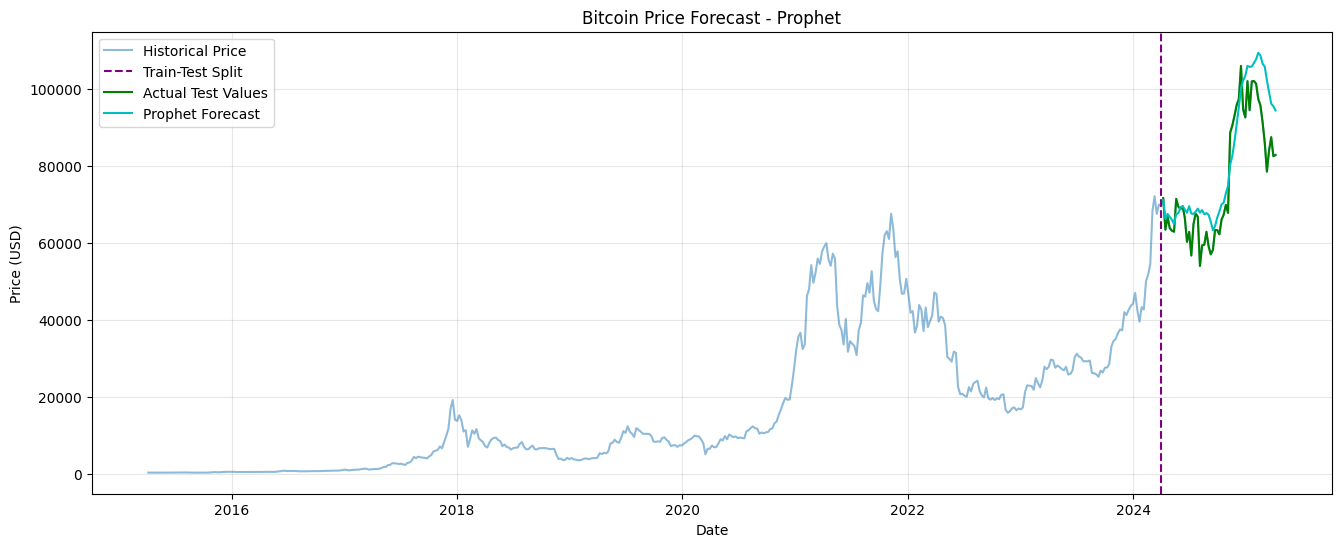

In [127]:
plt.figure(figsize=(16, 6))
plt.plot(btc_weekly.index, btc_weekly['bitcoin_price'], label='Historical Price', alpha=0.5)
plt.axvline(x=train_end_date, color='purple', linestyle='--', label='Train-Test Split')
plt.plot(test_dates, test_actual_arr, 'g-', label='Actual Test Values')
plt.plot(test_dates, prophet_forecast, 'c-', label='Prophet Forecast')
plt.title("Bitcoin Price Forecast - Prophet")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

In [118]:
import yfinance as yf
import pandas as pd

def load_btc_data_p(period="10y", csv_file_weekly="btc_weekly_data.csv"):
    """
    Fetches Bitcoin data from Yahoo Finance and resamples it to weekly frequency.
    Retains all relevant columns for advanced modeling.

    Parameters:
        period (str): Time period for the data (e.g., "5y", "10y", "max").
        csv_file_weekly (str): Path to save the resampled weekly data.

    Returns:
        pd.DataFrame: Resampled weekly DataFrame with added 'bitcoin_price' column.
    """
    print(f"Fetching BTC-USD data from Yahoo Finance for the past {period}...")
    btc = yf.Ticker("BTC-USD")
    btc_data = btc.history(period=period)  # daily data

    # Drop timezone
    btc_data.index = pd.to_datetime(btc_data.index).tz_localize(None)

    # Resample to weekly (e.g., last value on Monday)
    btc_weekly = btc_data.resample('W-MON').last().dropna()

    # Add alias column for Prophet
    btc_weekly['bitcoin_price'] = btc_weekly['Close']

    # Save all columns
    btc_weekly.to_csv(csv_file_weekly)
    print(f"Weekly data saved to {csv_file_weekly} with shape {btc_weekly.shape}.")

    return btc_weekly
btc_df = load_btc_data_p(period="10y")
btc_df.head()


Fetching BTC-USD data from Yahoo Finance for the past 10y...
Weekly data saved to btc_weekly_data.csv with shape (523, 8).


,Open,High,Low,Close,Volume,Dividends,Stock Splits,bitcoin_price
Date,,,,,,,,
2015-04-06,260.721008,261.798004,254.574997,255.492004,20034200,0.0,0.0,255.492004
2015-04-13,235.949997,236.934998,221.996002,224.587006,31181800,0.0,0.0,224.587006
2015-04-20,222.612000,226.350998,221.977005,224.626007,18364700,0.0,0.0,224.626007
2015-04-27,219.429001,233.304993,218.022995,229.285995,38574000,0.0,0.0,229.285995
2015-05-04,240.356003,242.638000,237.809998,239.018005,21223400,0.0,0.0,239.018005


##LSTM model

In [189]:
# # ========== 6) LSTM MODELING ==========

# ---- 6.1) Data scaling ----
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_btc = scaler.fit_transform(btc_weekly['bitcoin_price'].values.reshape(-1, 1))

scaled_train = scaled_btc[:train_size]
scaled_test = scaled_btc[train_size:]

# Create sequences
def create_sequences(data_array, seq_length):
    X, y = [], []
    for i in range(len(data_array) - seq_length):
        X.append(data_array[i:i+seq_length])
        y.append(data_array[i+seq_length])
    return np.array(X), np.array(y)

seq_length = 52  # e.g., 52 weeks to predict next week
X_train_arr, y_train_arr = create_sequences(scaled_train, seq_length)
X_test_arr, y_test_arr   = create_sequences(scaled_test, seq_length)

# Convert to PyTorch tensors
X_train_tensor = torch.FloatTensor(X_train_arr)
y_train_tensor = torch.FloatTensor(y_train_arr)
X_test_tensor = torch.FloatTensor(X_test_arr)
y_test_tensor = torch.FloatTensor(y_test_arr)

# ---- 6.2) Create Dataset and DataLoader ----
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_dataset = TimeSeriesDataset(X_train_tensor, y_train_tensor)
test_dataset  = TimeSeriesDataset(X_test_tensor, y_test_tensor)

train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
test_loader  = DataLoader(test_dataset,  batch_size=32, shuffle=False)

# ---- 6.3) Define LSTM model (using updated architecture) ----
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class LSTModel(nn.Module):
    def __init__(self, input_size=1, hidden_size=128, num_layers=2, output_size=1, dropout_rate=0.3):
        super(LSTModel, self).__init__()
        self.input_size = input_size
        self.hidden_size = hidden_size
        self.output_size = output_size
        self.num_layers = num_layers
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout_rate)
        self.linear = nn.Linear(hidden_size, output_size)
        self.relu = nn.ReLU()
        self.dropout = nn.Dropout(dropout_rate)

    def forward(self, x):
        h0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        c0 = torch.zeros(self.num_layers, x.size(0), self.hidden_size).to(device)
        out, _ = self.lstm(x, (h0, c0))
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.relu(out)
        out = self.linear(out)
        return out

# Create model instance
lstm_model = LSTModel(input_size=1, hidden_size=128, num_layers=2).to(device)

# ---- 6.4) Train LSTM model ----
num_epochs = 50
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(lstm_model.parameters(), lr=0.001)

best_loss = float('inf')
patience = 10
no_improvement_counter = 0

X_train_tensor = X_train_tensor.to(device)
y_train_tensor = y_train_tensor.to(device)

for epoch in range(num_epochs):
    lstm_model.train()
    total_loss = 0

    for X_batch, y_batch in train_loader:
        X_batch = X_batch.to(device)
        y_batch = y_batch.to(device)

        optimizer.zero_grad()
        outputs = lstm_model(X_batch)
        loss = criterion(outputs, y_batch)
        loss.backward()
        optimizer.step()

        total_loss += loss.item()

    epoch_loss = total_loss / len(train_loader)
    print(f"Epoch [{epoch+1}/{num_epochs}], Loss: {epoch_loss:.5f}")

    # Basic early stopping
    if epoch_loss < best_loss:
        best_loss = epoch_loss
        torch.save(lstm_model.state_dict(), 'best_lstm_model.pth')
        no_improvement_counter = 0
    else:
        no_improvement_counter += 1
        if no_improvement_counter >= patience:
            print("Early stopping triggered.")
            break

# Load best model
lstm_model.load_state_dict(torch.load('best_lstm_model.pth'))
lstm_model.eval()

# ---- 6.5) Forecast with LSTM (Recursive) ----
def recursive_forecast(model, initial_seq, steps):
    model.eval()
    input_seq = torch.FloatTensor(initial_seq).to(device)
    predictions = []

    with torch.no_grad():
        for _ in range(steps):
            x_input = input_seq.unsqueeze(0)  # (batch=1, seq_length, 1)
            pred = model(x_input)
            predictions.append(pred.item())
            input_seq = torch.cat([input_seq[1:], pred.reshape(1, 1)], dim=0)

    return np.array(predictions).reshape(-1, 1)

# Get the last sequence from the entire scaled training data
last_train_seq = scaled_train[-seq_length:]
steps_to_predict = len(scaled_test)

lstm_pred_scaled = recursive_forecast(lstm_model, last_train_seq, steps_to_predict)
lstm_forecast = scaler.inverse_transform(lstm_pred_scaled)


Epoch [1/50], Loss: 0.05050
Epoch [2/50], Loss: 0.02725
Epoch [3/50], Loss: 0.02251
Epoch [4/50], Loss: 0.01233
Epoch [5/50], Loss: 0.01178
Epoch [6/50], Loss: 0.00593
Epoch [7/50], Loss: 0.00513
Epoch [8/50], Loss: 0.00476
Epoch [9/50], Loss: 0.00410
Epoch [10/50], Loss: 0.00449
Epoch [11/50], Loss: 0.00345
Epoch [12/50], Loss: 0.00359
Epoch [13/50], Loss: 0.00390
Epoch [14/50], Loss: 0.00246
Epoch [15/50], Loss: 0.00436
Epoch [16/50], Loss: 0.00319
Epoch [17/50], Loss: 0.00361
Epoch [18/50], Loss: 0.00344
Epoch [19/50], Loss: 0.00353
Epoch [20/50], Loss: 0.00250
Epoch [21/50], Loss: 0.00285
Epoch [22/50], Loss: 0.00277
Epoch [23/50], Loss: 0.00234
Epoch [24/50], Loss: 0.00356
Epoch [25/50], Loss: 0.00467
Epoch [26/50], Loss: 0.00293
Epoch [27/50], Loss: 0.00234
Epoch [28/50], Loss: 0.00185
Epoch [29/50], Loss: 0.00236
Epoch [30/50], Loss: 0.00220
Epoch [31/50], Loss: 0.00169
Epoch [32/50], Loss: 0.00175
Epoch [33/50], Loss: 0.00239
Epoch [34/50], Loss: 0.00158
Epoch [35/50], Loss: 0.

#EVALUATE PERFORMANCE METRICS

In [190]:
# LSTM
lstm_mae = mean_absolute_error(test_actual_arr, lstm_forecast.flatten())
lstm_mse = mean_squared_error(test_actual_arr, lstm_forecast.flatten())
lstm_rmse = np.sqrt(lstm_mse)
lstm_mape = np.mean(np.abs((test_actual_arr - lstm_forecast.flatten()) / test_actual_arr)) * 100
print(f"LSTM - MAE: {lstm_mae:.2f}, MSE: {lstm_mse:.2f}, RMSE: {lstm_rmse:.2f}, MAPE: {lstm_mape:.2f}%")

LSTM - MAE: 25103.18, MSE: 917331891.14, RMSE: 30287.49, MAPE: 30.16%


 VISUALIZATION

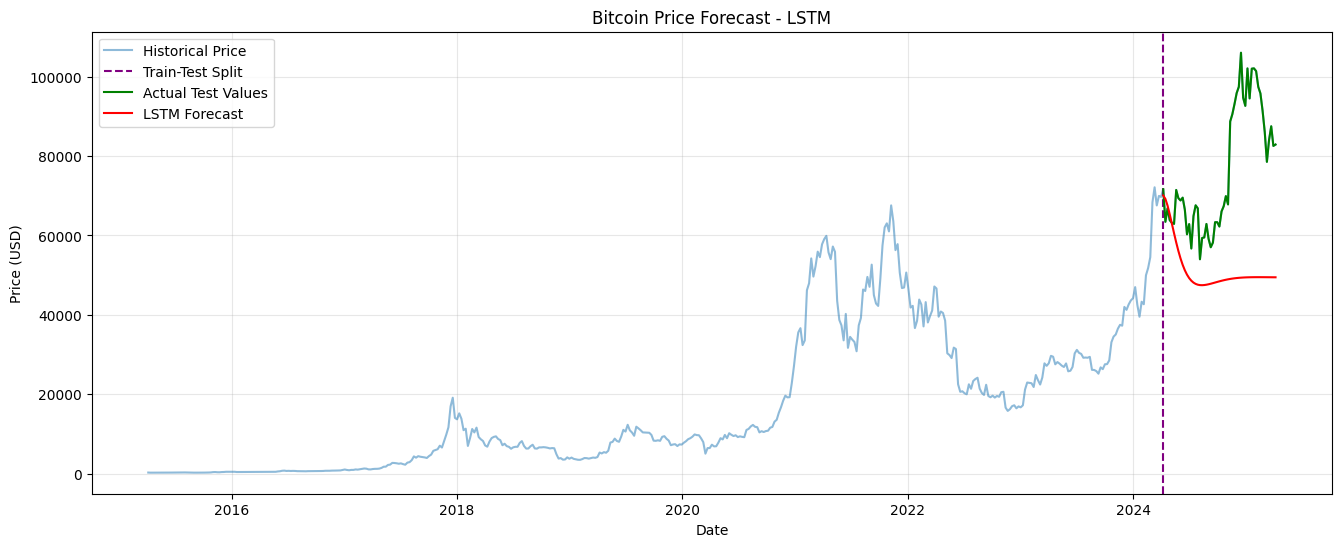

In [192]:
plt.figure(figsize=(16, 6))
plt.plot(btc_weekly.index, btc_weekly['bitcoin_price'], label='Historical Price', alpha=0.5)
plt.axvline(x=train_end_date, color='purple', linestyle='--', label='Train-Test Split')
plt.plot(test_dates, test_actual_arr, 'g-', label='Actual Test Values')
plt.plot(test_dates, lstm_forecast, 'm-',color='red', label='LSTM Forecast')
plt.title("Bitcoin Price Forecast - LSTM")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

CNN-LSTM

In [167]:
import random
import numpy as np
import torch

def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)


Epoch 1 | Train Loss: 0.0269
Epoch 2 | Train Loss: 0.0204
Epoch 3 | Train Loss: 0.0089
Epoch 4 | Train Loss: 0.0063
Epoch 5 | Train Loss: 0.0061
Epoch 6 | Train Loss: 0.0042
Epoch 7 | Train Loss: 0.0040
Epoch 8 | Train Loss: 0.0035
Epoch 9 | Train Loss: 0.0034
Epoch 10 | Train Loss: 0.0030
Epoch 11 | Train Loss: 0.0022
Epoch 12 | Train Loss: 0.0024
Epoch 13 | Train Loss: 0.0022
Epoch 14 | Train Loss: 0.0024
Epoch 15 | Train Loss: 0.0029
Epoch 16 | Train Loss: 0.0020
Epoch 17 | Train Loss: 0.0019
Epoch 18 | Train Loss: 0.0023
Epoch 19 | Train Loss: 0.0019
Epoch 20 | Train Loss: 0.0021
Epoch 21 | Train Loss: 0.0020
Epoch 22 | Train Loss: 0.0021
Epoch 23 | Train Loss: 0.0018
Epoch 24 | Train Loss: 0.0019
Epoch 25 | Train Loss: 0.0019
Epoch 26 | Train Loss: 0.0018
Epoch 27 | Train Loss: 0.0019
Epoch 28 | Train Loss: 0.0018
Epoch 29 | Train Loss: 0.0020
Epoch 30 | Train Loss: 0.0020
Epoch 31 | Train Loss: 0.0016
Epoch 32 | Train Loss: 0.0018
Epoch 33 | Train Loss: 0.0016
Epoch 34 | Train Lo

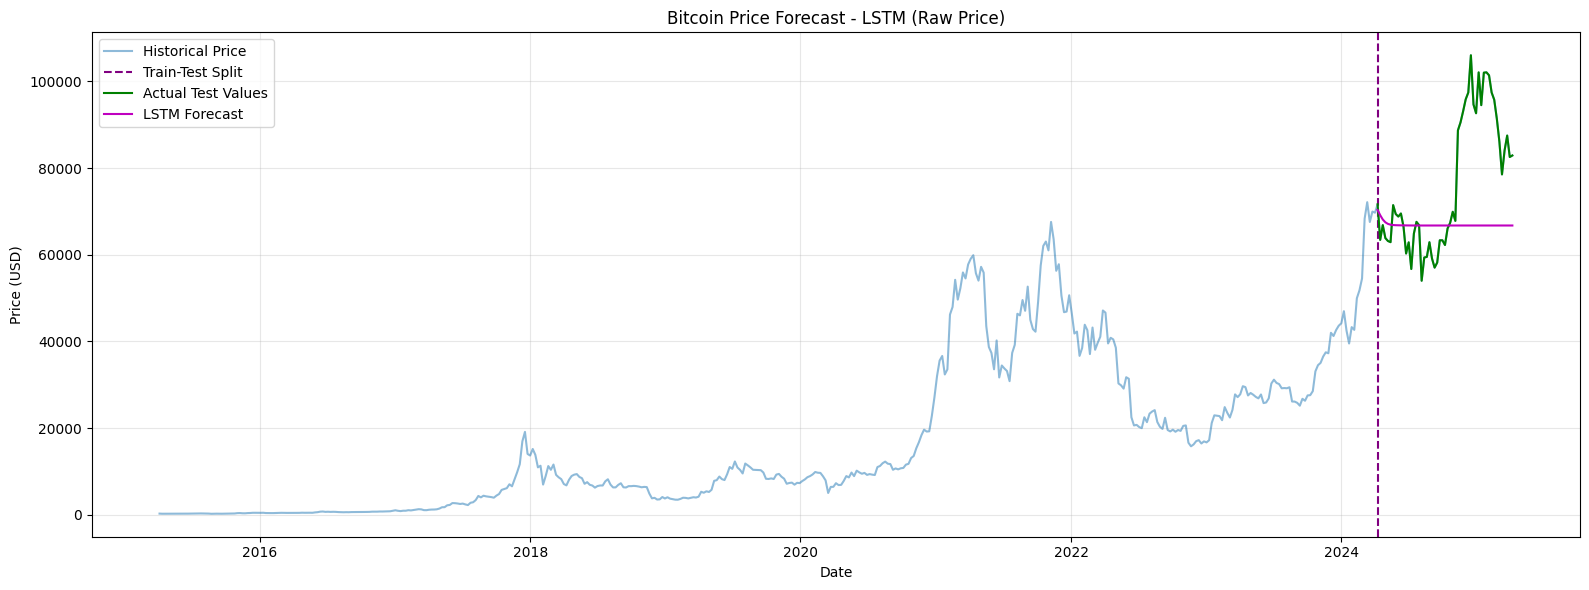

In [187]:
# ===========================
# CNN-LSTM Recursive Forecast on Actual Prices (90% Train, 10% Test)
# ===========================

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.nn as nn
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_absolute_error, mean_squared_error
import random

# ---------- Set seed ----------
def set_seed(seed=42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(42)

# ---------- Feature Engineering ----------
btc_df['ma_7'] = btc_df['bitcoin_price'].rolling(window=7, min_periods=1).mean()
btc_df['volatility'] = btc_df['bitcoin_price'].rolling(window=7).std().fillna(0)
btc_df['momentum'] = btc_df['bitcoin_price'] - btc_df['bitcoin_price'].shift(7).fillna(method='bfill')

btc_df = btc_df.dropna()

# ---------- Scaling features ----------
features = ['bitcoin_price', 'Volume', 'ma_7', 'volatility', 'momentum']
scalers = {}
scaled_data = pd.DataFrame(index=btc_df.index)
for col in features:
    scaler = MinMaxScaler()
    scaled_data[col] = scaler.fit_transform(btc_df[[col]])
    scalers[col] = scaler

# ---------- Split data ----------
seq_length = 52
train_size = int(len(scaled_data) * 0.9)
train_data = scaled_data[:train_size]
test_data = scaled_data[train_size - seq_length:]

train_end_date = btc_df.index[train_size]
test_dates = btc_df.index[train_size:]
test_actual_prices = btc_df['bitcoin_price'].iloc[train_size:]

# ---------- Sequence creation ----------
def create_sequences(data_array, seq_length):
    X, y = [], []
    for i in range(len(data_array) - seq_length):
        X.append(data_array[i:i+seq_length])
        y.append(data_array[i+seq_length, 0])  # target = bitcoin_price
    return np.array(X), np.array(y)

scaled_array = scaled_data[features].values
scaled_train = scaled_array[:train_size]
scaled_test = scaled_array[train_size - seq_length:]

X_train, y_train = create_sequences(scaled_train, seq_length)

# ---------- Dataset ----------
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = torch.tensor(X, dtype=torch.float32)
        self.y = torch.tensor(y, dtype=torch.float32)
    def __len__(self):
        return len(self.X)
    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

train_loader = DataLoader(TimeSeriesDataset(X_train, y_train), batch_size=32, shuffle=True)

# ---------- LSTM Model ----------
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

class LSTMModel(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=2, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            dropout=dropout, batch_first=True)
        self.fc = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout)
        self.relu = nn.ReLU()
    def forward(self, x):
        out, _ = self.lstm(x)
        out = out[:, -1, :]
        out = self.dropout(out)
        out = self.fc(self.relu(out))
        return out

model = LSTMModel(input_size=len(features)).to(device)

# ---------- Training ----------
criterion = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.0005)
best_loss = float('inf')
patience = 10
no_improve = 0

for epoch in range(50):
    model.train()
    train_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        output = model(X_batch).squeeze()
        loss = criterion(output, y_batch)
        loss.backward()
        optimizer.step()
        train_loss += loss.item()
    train_loss /= len(train_loader)
    print(f"Epoch {epoch+1} | Train Loss: {train_loss:.4f}")
    if train_loss < best_loss:
        best_loss = train_loss
        torch.save(model.state_dict(), "best_lstm_price.pth")
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping triggered.")
            break

# ---------- Recursive Forecast on Raw Price ----------
def recursive_forecast_price(model, initial_seq, steps):
    model.eval()
    input_seq = torch.FloatTensor(initial_seq).to(device)
    predictions = []
    with torch.no_grad():
        for _ in range(steps):
            x_input = input_seq.unsqueeze(0)
            pred = model(x_input)
            predictions.append(pred.item())
            next_row = input_seq[-1].clone()
            next_row[0] = pred  # update bitcoin_price only
            input_seq = torch.cat([input_seq[1:], next_row.unsqueeze(0)], dim=0)
    return np.array(predictions).reshape(-1, 1)

model.load_state_dict(torch.load("best_lstm_price.pth"))

initial_seq = scaled_test[:seq_length]
steps = len(test_actual_prices)
price_pred_scaled = recursive_forecast_price(model, initial_seq, steps)

# Inverse scale predictions
lstm_forecast = scalers['bitcoin_price'].inverse_transform(price_pred_scaled).flatten()

# ---------- Evaluation ----------
mae = mean_absolute_error(test_actual_prices, lstm_forecast)
rmse = np.sqrt(mean_squared_error(test_actual_prices, lstm_forecast))
print(f"\nTest MAE: {mae:.2f}, RMSE: {rmse:.2f}")

# ---------- Plot ----------
plt.figure(figsize=(16, 6))
plt.plot(btc_df.index, btc_df['bitcoin_price'], label='Historical Price', alpha=0.5)
plt.axvline(x=train_end_date, color='purple', linestyle='--', label='Train-Test Split')
plt.plot(test_dates, test_actual_prices, 'g-', label='Actual Test Values')
plt.plot(test_dates, lstm_forecast, 'm-', label='LSTM Forecast')
plt.title("Bitcoin Price Forecast - LSTM (Raw Price)")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

Attention LSTM

[Attn LSTM] Epoch 1 | Loss: 0.0317
[Attn LSTM] Epoch 2 | Loss: 0.0207
[Attn LSTM] Epoch 3 | Loss: 0.0152
[Attn LSTM] Epoch 4 | Loss: 0.0120
[Attn LSTM] Epoch 5 | Loss: 0.0113
[Attn LSTM] Epoch 6 | Loss: 0.0119
[Attn LSTM] Epoch 7 | Loss: 0.0103
[Attn LSTM] Epoch 8 | Loss: 0.0102
[Attn LSTM] Epoch 9 | Loss: 0.0097
[Attn LSTM] Epoch 10 | Loss: 0.0088
[Attn LSTM] Epoch 11 | Loss: 0.0101
[Attn LSTM] Epoch 12 | Loss: 0.0085
[Attn LSTM] Epoch 13 | Loss: 0.0086
[Attn LSTM] Epoch 14 | Loss: 0.0073
[Attn LSTM] Epoch 15 | Loss: 0.0083
[Attn LSTM] Epoch 16 | Loss: 0.0085
[Attn LSTM] Epoch 17 | Loss: 0.0075
[Attn LSTM] Epoch 18 | Loss: 0.0076
[Attn LSTM] Epoch 19 | Loss: 0.0072
[Attn LSTM] Epoch 20 | Loss: 0.0067
[Attn LSTM] Epoch 21 | Loss: 0.0065
[Attn LSTM] Epoch 22 | Loss: 0.0063
[Attn LSTM] Epoch 23 | Loss: 0.0060
[Attn LSTM] Epoch 24 | Loss: 0.0077
[Attn LSTM] Epoch 25 | Loss: 0.0077
[Attn LSTM] Epoch 26 | Loss: 0.0066
[Attn LSTM] Epoch 27 | Loss: 0.0057
[Attn LSTM] Epoch 28 | Loss: 0.0052
[

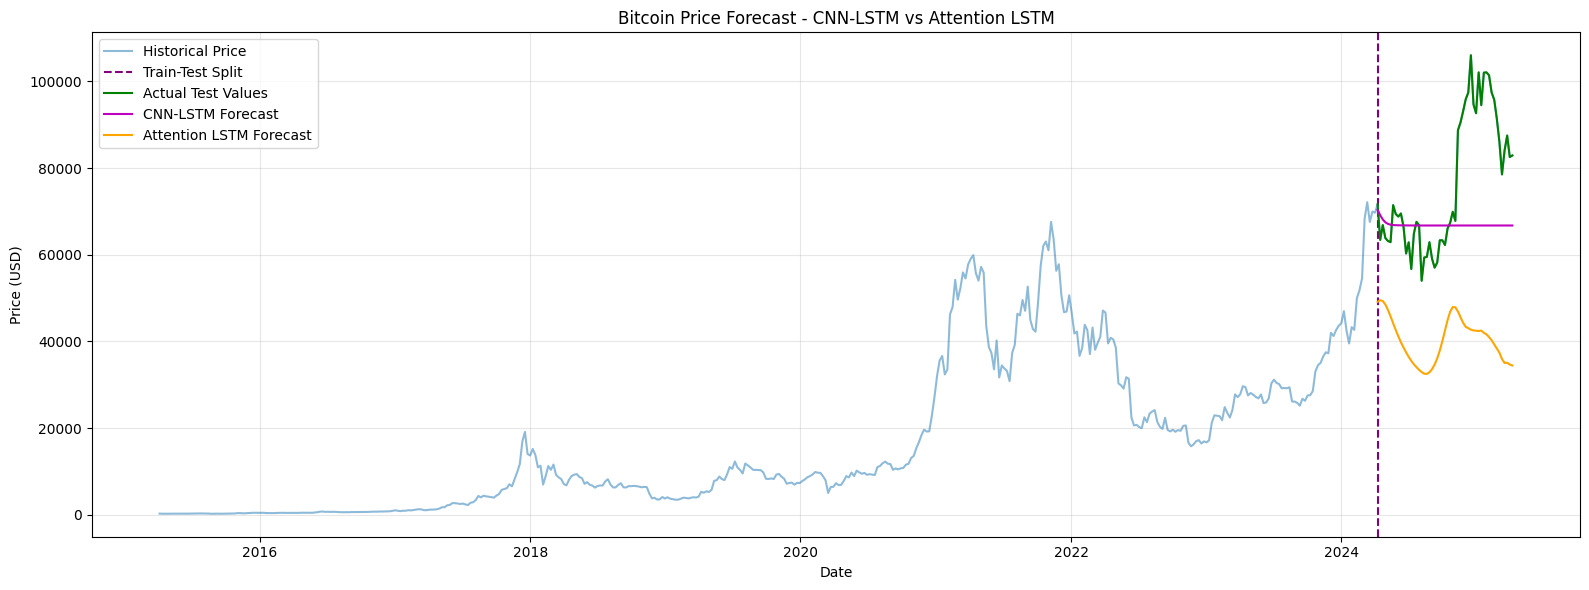

In [188]:
# ===========================
# CNN-LSTM and Attention LSTM Forecast on Actual Prices (90% Train, 10% Test)
# ===========================



# ---------- Attention-based LSTM Model ----------
class AttentionLSTM(nn.Module):
    def __init__(self, input_size, hidden_size=128, num_layers=1, dropout=0.3):
        super().__init__()
        self.lstm = nn.LSTM(input_size, hidden_size, num_layers,
                            batch_first=True, dropout=dropout)
        self.attn = nn.Linear(hidden_size, 1)
        self.dropout = nn.Dropout(dropout)
        self.fc = nn.Linear(hidden_size, 1)

    def forward(self, x):
        lstm_out, _ = self.lstm(x)  # (B, T, H)
        attn_weights = torch.softmax(self.attn(lstm_out), dim=1)  # (B, T, 1)
        context = torch.sum(attn_weights * lstm_out, dim=1)  # (B, H)
        out = self.dropout(context)
        return self.fc(out)

attn_model = AttentionLSTM(input_size=len(features)).to(device)

# ---------- Train Attention LSTM ----------
attn_optimizer = torch.optim.Adam(attn_model.parameters(), lr=0.0005)
best_attn_loss = float('inf')
no_improve = 0

for epoch in range(50):
    attn_model.train()
    total_loss = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        attn_optimizer.zero_grad()
        output = attn_model(X_batch).squeeze()
        loss = criterion(output, y_batch)
        loss.backward()
        attn_optimizer.step()
        total_loss += loss.item()
    avg_loss = total_loss / len(train_loader)
    print(f"[Attn LSTM] Epoch {epoch+1} | Loss: {avg_loss:.4f}")
    if avg_loss < best_attn_loss:
        best_attn_loss = avg_loss
        torch.save(attn_model.state_dict(), "best_attn_lstm.pth")
        no_improve = 0
    else:
        no_improve += 1
        if no_improve >= patience:
            print("Early stopping (Attn LSTM)")
            break

# ---------- Recursive Forecast for Attention LSTM ----------
def recursive_forecast_attn(model, initial_seq, steps):
    model.eval()
    input_seq = torch.FloatTensor(initial_seq).to(device)
    predictions = []
    with torch.no_grad():
        for _ in range(steps):
            x_input = input_seq.unsqueeze(0)
            pred = model(x_input)
            predictions.append(pred.item())
            next_row = input_seq[-1].clone()
            next_row[0] = pred
            input_seq = torch.cat([input_seq[1:], next_row.unsqueeze(0)], dim=0)
    return np.array(predictions).reshape(-1, 1)

attn_model.load_state_dict(torch.load("best_attn_lstm.pth"))
attn_forecast_scaled = recursive_forecast_attn(attn_model, initial_seq, steps)
attn_forecast = scalers['bitcoin_price'].inverse_transform(attn_forecast_scaled).flatten()

# ---------- Evaluation for Attention LSTM ----------
attn_mae = mean_absolute_error(test_actual_prices, attn_forecast)
attn_rmse = np.sqrt(mean_squared_error(test_actual_prices, attn_forecast))
print(f"\n[Attn LSTM] Test MAE: {attn_mae:.2f}, RMSE: {attn_rmse:.2f}")

# ---------- Plot Both Forecasts ----------
plt.figure(figsize=(16, 6))
plt.plot(btc_df.index, btc_df['bitcoin_price'], label='Historical Price', alpha=0.5)
plt.axvline(x=train_end_date, color='purple', linestyle='--', label='Train-Test Split')
plt.plot(test_dates, test_actual_prices, 'g-', label='Actual Test Values')
plt.plot(test_dates, lstm_forecast, 'm-', label='CNN-LSTM Forecast')
plt.plot(test_dates, attn_forecast, 'orange', label='Attention LSTM Forecast')
plt.title("Bitcoin Price Forecast - CNN-LSTM vs Attention LSTM")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

#  Final Comparison: All models on a single plot

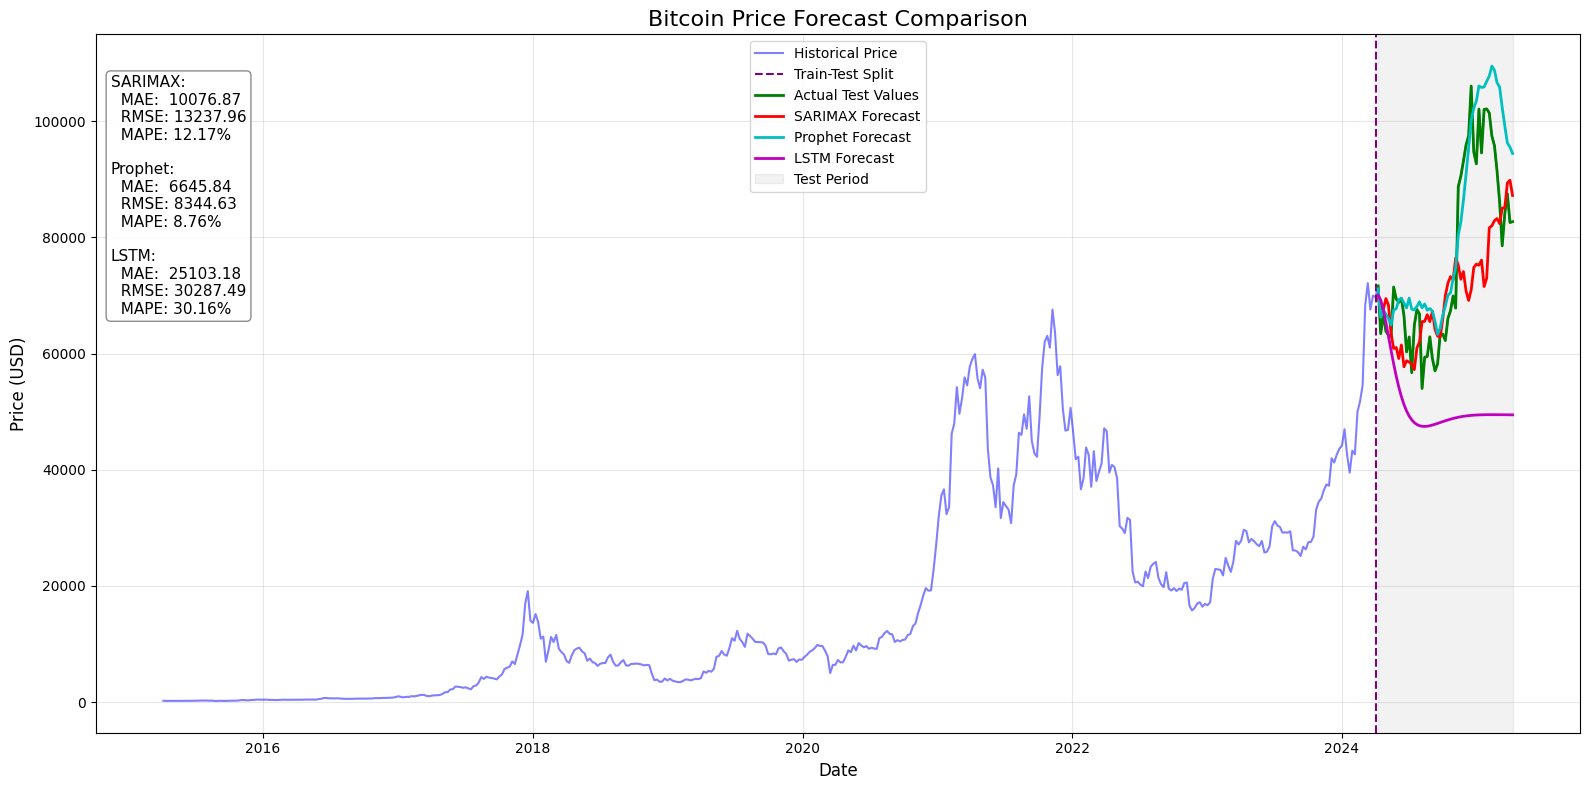

=== MODEL PERFORMANCE METRICS ===

SARIMAX:
  MAE:  10076.87
  RMSE: 13237.96
  MAPE: 12.17%

Prophet:
  MAE:  6645.84
  RMSE: 8344.63
  MAPE: 8.76%

LSTM:
  MAE:  25103.18
  RMSE: 30287.49
  MAPE: 30.16%

Comparison complete. All results visualized successfully.


In [214]:
# ---- 8.2) Final Comparison: All models on a single plot ----
plt.figure(figsize=(16, 8))

# Full historical
plt.plot(btc_weekly.index, btc_weekly['bitcoin_price'], 'b-', alpha=0.5, label='Historical Price')

# Train/Test split line
plt.axvline(x=train_end_date, color='purple', linestyle='--', label='Train-Test Split')

# Test actual
plt.plot(test_dates, test_actual_arr, 'g-', linewidth=2, label='Actual Test Values')

# Model forecasts
plt.plot(test_dates, sarimax_forecast, 'r-', linewidth=2, label='SARIMAX Forecast')
plt.plot(test_dates, prophet_forecast, 'c-', linewidth=2, label='Prophet Forecast')
plt.plot(test_dates, lstm_forecast, 'm-', linewidth=2, label='LSTM Forecast')

# Highlight test period
plt.axvspan(test_dates[0], test_dates[-1], alpha=0.1, color='gray', label='Test Period')

# Title, labels, legend
plt.title("Bitcoin Price Forecast Comparison", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price (USD)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Annotation of metrics
metrics_text = (
    f"SARIMAX:\n"
    f"  MAE:  {sarimax_mae:.2f}\n"
    f"  RMSE: {sarimax_rmse:.2f}\n"
    f"  MAPE: {sarimax_mape:.2f}%\n\n"
    f"Prophet:\n"
    f"  MAE:  {prophet_mae:.2f}\n"
    f"  RMSE: {prophet_rmse:.2f}\n"
    f"  MAPE: {prophet_mape:.2f}%\n\n"
    f"LSTM:\n"
    f"  MAE:  {lstm_mae:.2f}\n"
    f"  RMSE: {lstm_rmse:.2f}\n"
    f"  MAPE: {lstm_mape:.2f}%"
)

plt.annotate(metrics_text,
             xy=(0.01, 0.6),
             xycoords='axes fraction',
             fontsize=11,
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.9))

plt.tight_layout()
plt.show()

print("=== MODEL PERFORMANCE METRICS ===\n")
print("SARIMAX:")
print(f"  MAE:  {sarimax_mae:.2f}")
print(f"  RMSE: {sarimax_rmse:.2f}")
print(f"  MAPE: {sarimax_mape:.2f}%\n")

print("Prophet:")
print(f"  MAE:  {prophet_mae:.2f}")
print(f"  RMSE: {prophet_rmse:.2f}")
print(f"  MAPE: {prophet_mape:.2f}%\n")

print("LSTM:")
print(f"  MAE:  {lstm_mae:.2f}")
print(f"  RMSE: {lstm_rmse:.2f}")
print(f"  MAPE: {lstm_mape:.2f}%\n")

print("Comparison complete. All results visualized successfully.")

## Part 3 - Exogenous Variable

EXOGENOUS DATA: U.S. DOLLAR INDEX (DXY)

In [217]:
# ========== 2.1) LOAD EXOGENOUS DATA: U.S. DOLLAR INDEX (DXY) ==========

def load_dxy_data(period="10y", csv_file_weekly="dxy_weekly_data.csv"):
    """
    Fetch DXY (U.S. Dollar Index) data using yfinance for the specified period,
    then resample to weekly frequency (e.g., Monday close).
    The resulting DataFrame is saved as a CSV and returned.

    :param period: String representing the period to fetch (e.g., "10y", "5y", "max").
    :param csv_file_weekly: Path to CSV file to save weekly data.
    :return: pd.DataFrame of weekly DXY values with a 'dxy_index' column.
    """
    print(f"Fetching DXY index data from Yahoo Finance for the past {period}...")
    dxy = yf.Ticker("DX-Y.NYB")
    dxy_data = dxy.history(period=period)

    # Drop any timezone information
    dxy_data.index = pd.to_datetime(dxy_data.index).tz_localize(None)

    # Resample to weekly frequency (Monday close)
    dxy_weekly = dxy_data['Close'].resample('W-MON').last().dropna()

    # Rename column
    dxy_weekly = dxy_weekly.to_frame(name='dxy_index')

    # Save to CSV
    dxy_weekly.to_csv(csv_file_weekly)
    print(f"Weekly DXY data saved to {csv_file_weekly}.")

    return dxy_weekly

In [218]:
# Load both Bitcoin and DXY weekly data
btc_df = load_btc_data(period="5y")
dxy_df = load_dxy_data(period="5y")

# Merge into a single DataFrame for modeling or EDA
merged_df = btc_df.merge(dxy_df, left_index=True, right_index=True, how='inner')
print(merged_df.head())

Fetching BTC-USD data from Yahoo Finance for the past 5y...
Weekly data saved to btc_weekly_data.csv.
Fetching DXY index data from Yahoo Finance for the past 5y...
Weekly DXY data saved to dxy_weekly_data.csv.
            bitcoin_price   dxy_index
Date                                 
2020-04-06    7271.781250  100.690002
2020-04-13    6845.037598   99.349998
2020-04-20    6881.958496   99.959999
2020-04-27    7795.601074  100.040001
2020-05-04    8912.654297   99.480003


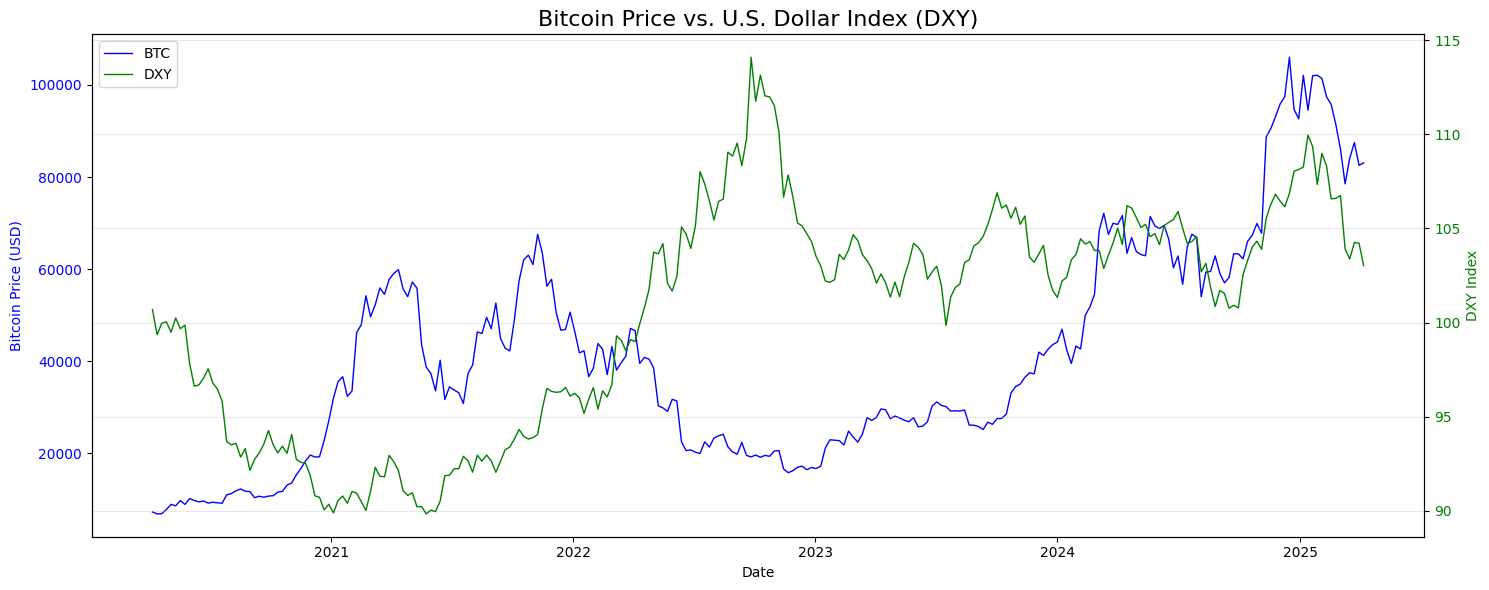

In [228]:
import matplotlib.pyplot as plt

def plot_btc_vs_dxy(df):
    """
    Plot Bitcoin price and DXY index on dual axes.

    :param df: DataFrame containing 'bitcoin_price' and 'dxy_index'.
    """
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Bitcoin Price (USD)", color='blue')
    line1, = ax1.plot(df.index, df['bitcoin_price'], color='blue', label="BTC", linewidth=1)
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel("DXY Index", color='green')
    line2, = ax2.plot(df.index, df['dxy_index'], color='green', label="DXY", linewidth=1)
    ax2.tick_params(axis='y', labelcolor='green')

    # Combine legends from both axes
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='upper left')

    plt.title("Bitcoin Price vs. U.S. Dollar Index (DXY)", fontsize=16)
    fig.tight_layout()
    plt.grid(alpha=0.3)
    plt.show()

plot_btc_vs_dxy(merged_df)


SARIMAx- bitcion with EXOGENOUS DATA: U.S. DOLLAR INDEX (DXY)

                                     SARIMAX Results                                      
Dep. Variable:                      bitcoin_price   No. Observations:                  235
Model:             SARIMAX(2, 1, 0)x(1, 1, 0, 52)   Log Likelihood               -1251.948
Date:                            Sat, 05 Apr 2025   AIC                           2513.896
Time:                                    19:14:27   BIC                           2528.156
Sample:                                04-06-2020   HQIC                          2519.690
                                     - 09-30-2024                                         
Covariance Type:                              opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
dxy_index   -537.1103    362.727     -1.481      0.139   -1248.041     173.821
ar.L1         -0.1082      0.173   

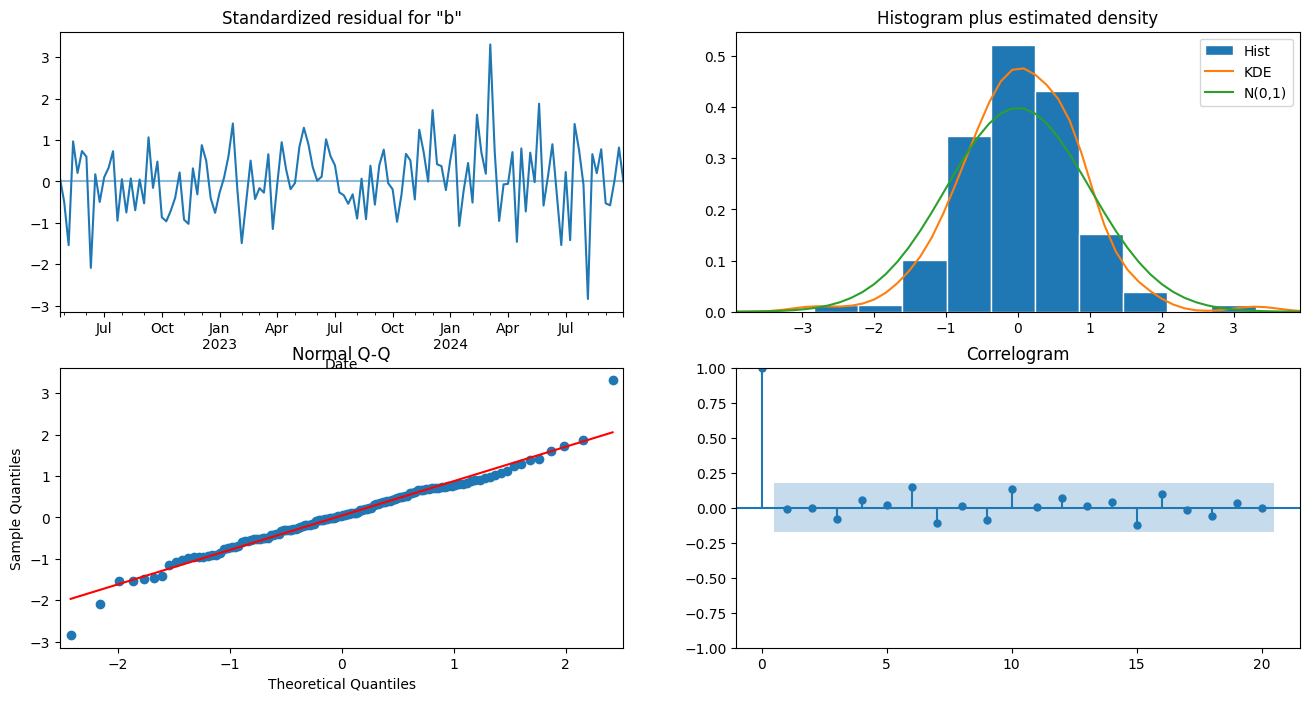

In [232]:
# fit SARIMAX model to btc_weekly data with hashprice
train_set = merged_df[:int(0.9*len(merged_df))]  # Split 90% of the data for training
test_set = merged_df[int(0.9*len(merged_df))-1:]  # Split the remaining 10% for testing
model = SARIMAX(train_set['bitcoin_price'], order=(2, 1, 0), seasonal_order=(1, 1, 0, 52), enforce_stationarity=False, enforce_invertibility=False,exog=train_set['dxy_index'])
results_dxy = model.fit()
print(results_dxy.summary())
fig = results_dxy.plot_diagnostics(figsize=(16, 8),lags = 20)
plt.show()

# Forecast the test set using the SARIMAX model
forecast = results_dxy.get_forecast(steps=len(test_set),exog = test_set['dxy_index'])

# Extract forecasted values and confidence intervals
forecast_values_exog = forecast.predicted_mean
forecast_ci = forecast.conf_int()

comparison - SARIMAX With vs Without Exogenous Variable

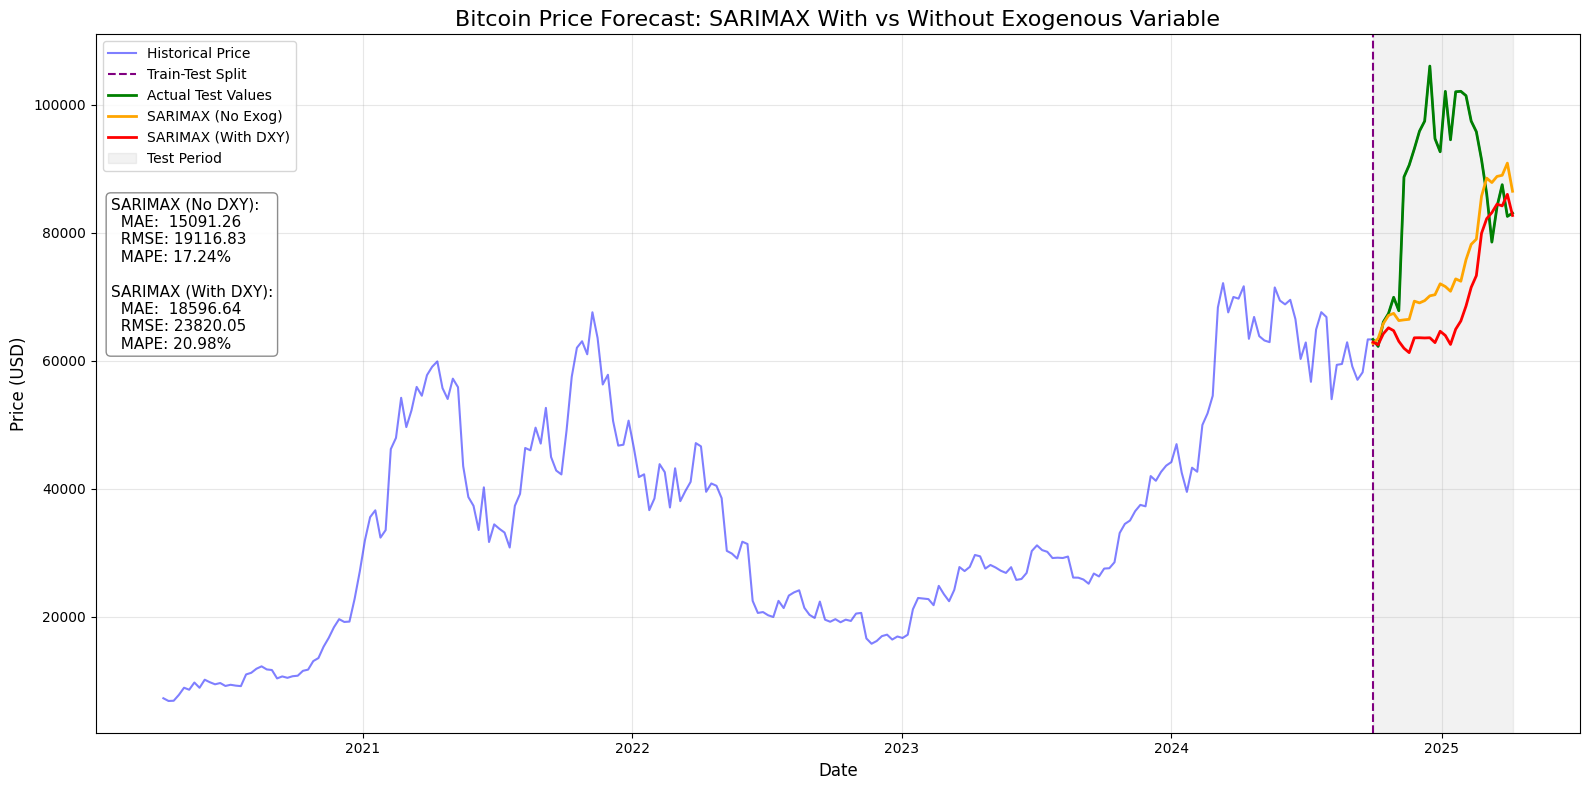

=== SARIMAX PERFORMANCE COMPARISON ===

WITHOUT Exogenous Variable:
  MAE:  15091.26
  RMSE: 19116.83
  MAPE: 17.24%

WITH Exogenous Variable (DXY):
  MAE:  18596.64
  RMSE: 23820.05
  MAPE: 20.98%

Comparison complete. Visualization and metrics show the effect of adding DXY as an exogenous variable.


In [235]:
# ---- 8.3) SARIMAX With vs Without Exogenous Variable ----
plt.figure(figsize=(16, 8))

# Historical data
plt.plot(merged_df.index, merged_df['bitcoin_price'], 'b-', alpha=0.5, label='Historical Price')

# Train/Test split
plt.axvline(x=test_set.index[0], color='purple', linestyle='--', label='Train-Test Split')

# Actual test values
plt.plot(test_set.index, test_set['bitcoin_price'], 'g-', linewidth=2, label='Actual Test Values')

# SARIMAX without exogenous variable
model_no_exog = SARIMAX(train_set['bitcoin_price'], order=(2, 1, 0), seasonal_order=(1, 1, 0, 52),
                        enforce_stationarity=False, enforce_invertibility=False)
results_no_exog = model_no_exog.fit()
forecast_no_exog = results_no_exog.get_forecast(steps=len(test_set))
forecast_values_no_exog = forecast_no_exog.predicted_mean

plt.plot(test_set.index, forecast_values_no_exog, 'orange', linewidth=2, label='SARIMAX (No Exog)')

# SARIMAX with exogenous variable
model_exog = SARIMAX(train_set['bitcoin_price'], order=(2, 1, 0), seasonal_order=(1, 1, 0, 52),
                     enforce_stationarity=False, enforce_invertibility=False,
                     exog=train_set['dxy_index'])
results_exog = model_exog.fit()
forecast_exog = results_exog.get_forecast(steps=len(test_set), exog=test_set['dxy_index'])
forecast_values_exog = forecast_exog.predicted_mean

plt.plot(test_set.index, forecast_values_exog, 'red', linewidth=2, label='SARIMAX (With DXY)')

# Highlight test period
plt.axvspan(test_set.index[0], test_set.index[-1], alpha=0.1, color='gray', label='Test Period')

# Title, labels, legend
plt.title("Bitcoin Price Forecast: SARIMAX With vs Without Exogenous Variable", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price (USD)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Evaluation metrics
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Errors
mae_no_exog = mean_absolute_error(test_set['bitcoin_price'], forecast_values_no_exog)
rmse_no_exog = np.sqrt(mean_squared_error(test_set['bitcoin_price'], forecast_values_no_exog))
mape_no_exog = np.mean(np.abs((test_set['bitcoin_price'] - forecast_values_no_exog) / test_set['bitcoin_price'])) * 100

mae_exog = mean_absolute_error(test_set['bitcoin_price'], forecast_values_exog)
rmse_exog = np.sqrt(mean_squared_error(test_set['bitcoin_price'], forecast_values_exog))
mape_exog = np.mean(np.abs((test_set['bitcoin_price'] - forecast_values_exog) / test_set['bitcoin_price'])) * 100

# Annotate metrics
metrics_text = (
    f"SARIMAX (No DXY):\n"
    f"  MAE:  {mae_no_exog:.2f}\n"
    f"  RMSE: {rmse_no_exog:.2f}\n"
    f"  MAPE: {mape_no_exog:.2f}%\n\n"
    f"SARIMAX (With DXY):\n"
    f"  MAE:  {mae_exog:.2f}\n"
    f"  RMSE: {rmse_exog:.2f}\n"
    f"  MAPE: {mape_exog:.2f}%"
)

plt.annotate(metrics_text,
             xy=(0.01, 0.55),
             xycoords='axes fraction',
             fontsize=11,
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.9))

plt.tight_layout()
plt.show()

# Console print
print("=== SARIMAX PERFORMANCE COMPARISON ===\n")
print("WITHOUT Exogenous Variable:")
print(f"  MAE:  {mae_no_exog:.2f}")
print(f"  RMSE: {rmse_no_exog:.2f}")
print(f"  MAPE: {mape_no_exog:.2f}%\n")

print("WITH Exogenous Variable (DXY):")
print(f"  MAE:  {mae_exog:.2f}")
print(f"  RMSE: {rmse_exog:.2f}")
print(f"  MAPE: {mape_exog:.2f}%\n")

print("Comparison complete. Visualization and metrics show the effect of adding DXY as an exogenous variable.")


EXOGENOUS DATA: BTC hashprice

In [236]:
hashprice_df = pd.read_csv('/content/bitcoin-hashprice-index-20250402.csv')
hashprice_df.head()

,timestamp,usd_hashprice,btc_hashprice
0,2025-04-02,47.54,0.000558
1,2025-04-01,46.93,0.000558
2,2025-03-31,45.90,0.000557
3,2025-03-30,46.19,0.000557
4,2025-03-29,46.48,0.000559


In [237]:
hashprice_df.index = pd.to_datetime(hashprice_df['timestamp'])

hashprice_df_weekly = hashprice_df[['usd_hashprice','btc_hashprice']].resample('W-MON').last().dropna()
hashprice_df_weekly.describe()

,usd_hashprice,btc_hashprice
count,262.000000,262.000000
mean,132.511183,0.004304
std,100.835359,0.003176
min,37.700000,0.000555
25%,63.662500,0.002036
50%,83.145000,0.003977
75%,177.595000,0.006493
max,408.370000,0.018225


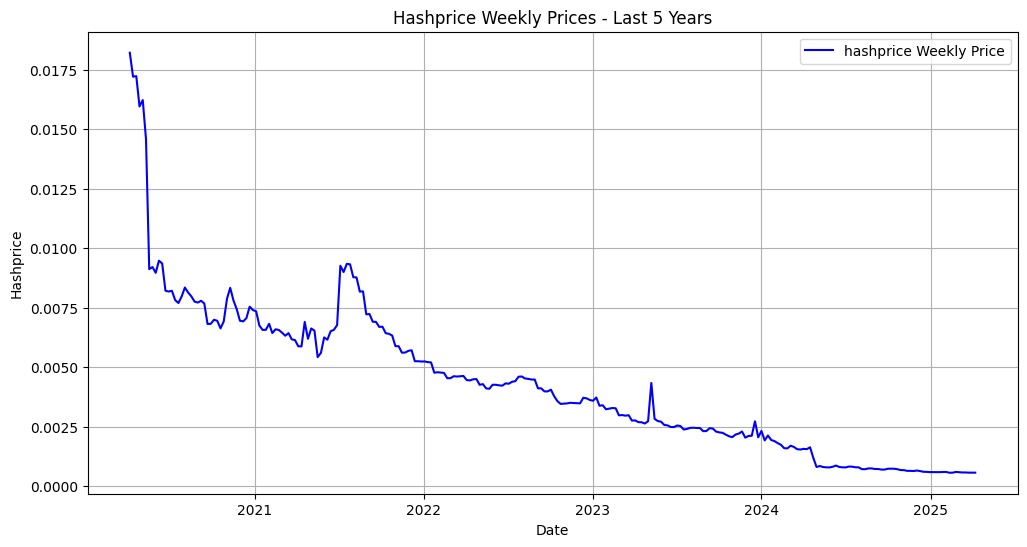

In [238]:
# Plot Bitcoin price trend (weekly data)
plt.figure(figsize=(12, 6))
plt.plot(hashprice_df_weekly.index, hashprice_df_weekly['btc_hashprice'], label='hashprice Weekly Price', color='blue')
# plt.plot(btc_weekly.index, btc_weekly, label='BTC-USD Weekly Closing Price', color='red')
plt.plot()
plt.xlabel("Date")
plt.ylabel("Hashprice")
plt.title("Hashprice Weekly Prices - Last 5 Years")
plt.legend()
plt.grid()
plt.show()


In [239]:
combined_df = pd.concat([btc_weekly, hashprice_df_weekly['btc_hashprice']], axis=1).dropna()
combined_df.columns = ['btc_price', 'btc_hashprice']
combined_df.head()

,btc_price,btc_hashprice
2020-04-06,7271.781250,0.018225
2020-04-13,6845.037598,0.017218
2020-04-20,6881.958496,0.017240
2020-04-27,7795.601074,0.015965
2020-05-04,8912.654297,0.016233


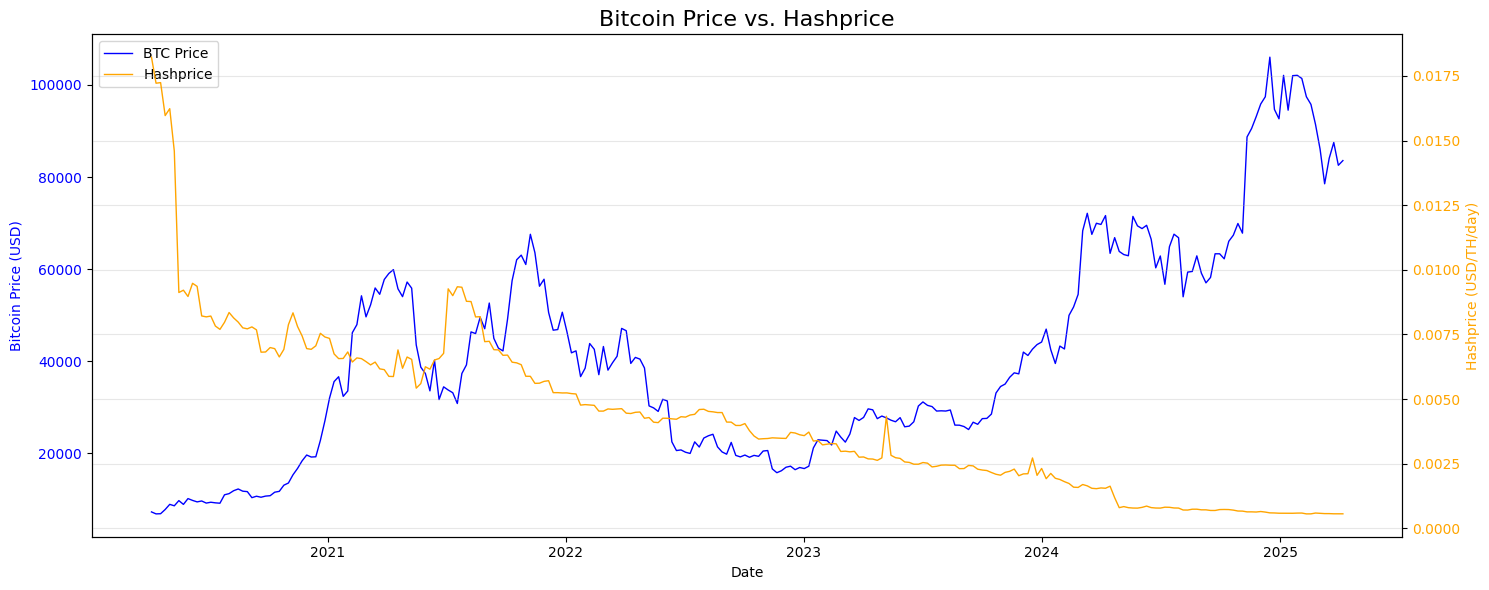

In [240]:
def plot_btc_vs_hashprice(df):
    """
    Plot Bitcoin price and Hashprice on dual axes.

    :param df: DataFrame containing 'btc_price' and 'btc_hashprice'.
    """
    fig, ax1 = plt.subplots(figsize=(15, 6))

    ax1.set_xlabel("Date")
    ax1.set_ylabel("Bitcoin Price (USD)", color='blue')
    line1, = ax1.plot(df.index, df['btc_price'], color='blue', label="BTC Price", linewidth=1)
    ax1.tick_params(axis='y', labelcolor='blue')

    ax2 = ax1.twinx()
    ax2.set_ylabel("Hashprice (USD/TH/day)", color='orange')
    line2, = ax2.plot(df.index, df['btc_hashprice'], color='orange', label="Hashprice", linewidth=1)
    ax2.tick_params(axis='y', labelcolor='orange')

    # Combine legends from both axes
    lines = [line1, line2]
    labels = [line.get_label() for line in lines]
    ax1.legend(lines, labels, loc='upper left')

    plt.title("Bitcoin Price vs. Hashprice", fontsize=16)
    fig.tight_layout()
    plt.grid(alpha=0.3)
    plt.show()

# שימוש
plot_btc_vs_hashprice(combined_df)


SARIMAx- bitcion with EXOGENOUS DATA: BTC hashprice + comparison - SARIMAX With vs Without Exogenous Variable

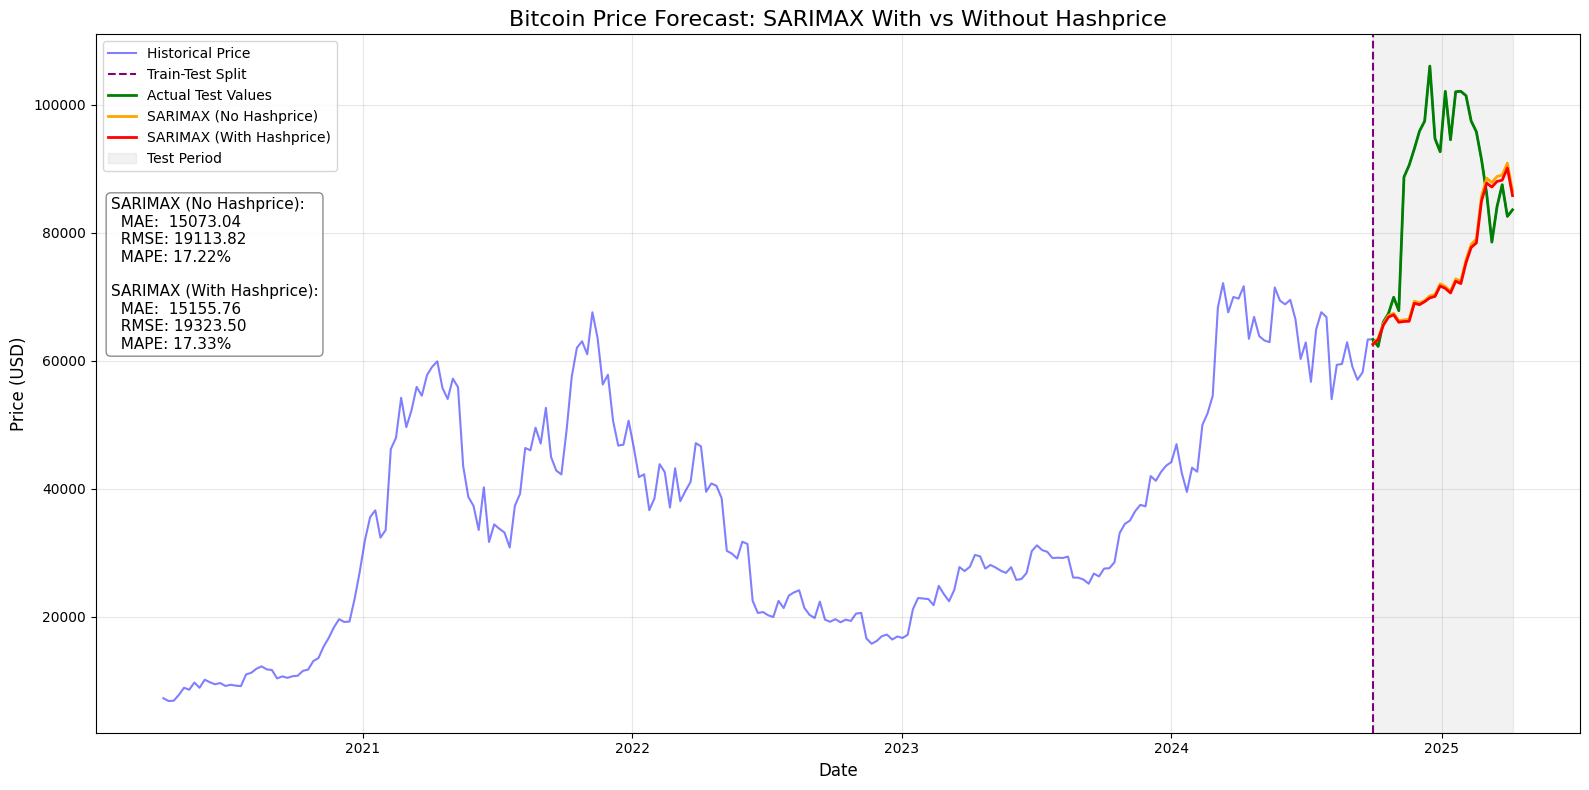

=== SARIMAX PERFORMANCE COMPARISON ===

WITHOUT Exogenous Variable:
  MAE:  15073.04
  RMSE: 19113.82
  MAPE: 17.22%

WITH Exogenous Variable (Hashprice):
  MAE:  15155.76
  RMSE: 19323.50
  MAPE: 17.33%

Comparison complete. Visualization and metrics show the effect of adding Hashprice as an exogenous variable.


In [242]:
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np
import matplotlib.pyplot as plt

# Create training and test sets
train_set = combined_df[:int(0.9 * len(combined_df))]
test_set = combined_df[int(0.9 * len(combined_df)) - 1:]

plt.figure(figsize=(16, 8))

# Plot historical data
plt.plot(combined_df.index, combined_df['btc_price'], 'b-', alpha=0.5, label='Historical Price')

# Plot train/test split line
plt.axvline(x=test_set.index[0], color='purple', linestyle='--', label='Train-Test Split')

# Plot actual test values
plt.plot(test_set.index, test_set['btc_price'], 'g-', linewidth=2, label='Actual Test Values')

# SARIMAX without exogenous variable
model_no_exog = SARIMAX(train_set['btc_price'], order=(2, 1, 0), seasonal_order=(1, 1, 0, 52),
                        enforce_stationarity=False, enforce_invertibility=False)
results_no_exog = model_no_exog.fit()
forecast_no_exog = results_no_exog.get_forecast(steps=len(test_set))
forecast_values_no_exog = forecast_no_exog.predicted_mean

plt.plot(test_set.index, forecast_values_no_exog, 'orange', linewidth=2, label='SARIMAX (No Hashprice)')

# SARIMAX with exogenous variable (btc_hashprice)
model_exog = SARIMAX(train_set['btc_price'], order=(2, 1, 0), seasonal_order=(1, 1, 0, 52),
                     enforce_stationarity=False, enforce_invertibility=False,
                     exog=train_set['btc_hashprice'])
results_exog = model_exog.fit()
forecast_exog = results_exog.get_forecast(steps=len(test_set), exog=test_set['btc_hashprice'])
forecast_values_exog = forecast_exog.predicted_mean

plt.plot(test_set.index, forecast_values_exog, 'red', linewidth=2, label='SARIMAX (With Hashprice)')

# Highlight the test period
plt.axvspan(test_set.index[0], test_set.index[-1], alpha=0.1, color='gray', label='Test Period')

# Titles, labels, legend
plt.title("Bitcoin Price Forecast: SARIMAX With vs Without Hashprice", fontsize=16)
plt.xlabel("Date", fontsize=12)
plt.ylabel("Price (USD)", fontsize=12)
plt.legend(fontsize=10)
plt.grid(True, alpha=0.3)

# Calculate evaluation metrics
mae_no_exog = mean_absolute_error(test_set['btc_price'], forecast_values_no_exog)
rmse_no_exog = np.sqrt(mean_squared_error(test_set['btc_price'], forecast_values_no_exog))
mape_no_exog = np.mean(np.abs((test_set['btc_price'] - forecast_values_no_exog) / test_set['btc_price'])) * 100

mae_exog = mean_absolute_error(test_set['btc_price'], forecast_values_exog)
rmse_exog = np.sqrt(mean_squared_error(test_set['btc_price'], forecast_values_exog))
mape_exog = np.mean(np.abs((test_set['btc_price'] - forecast_values_exog) / test_set['btc_price'])) * 100

# Display metrics on the plot
metrics_text = (
    f"SARIMAX (No Hashprice):\n"
    f"  MAE:  {mae_no_exog:.2f}\n"
    f"  RMSE: {rmse_no_exog:.2f}\n"
    f"  MAPE: {mape_no_exog:.2f}%\n\n"
    f"SARIMAX (With Hashprice):\n"
    f"  MAE:  {mae_exog:.2f}\n"
    f"  RMSE: {rmse_exog:.2f}\n"
    f"  MAPE: {mape_exog:.2f}%"
)

plt.annotate(metrics_text,
             xy=(0.01, 0.55),
             xycoords='axes fraction',
             fontsize=11,
             bbox=dict(boxstyle="round,pad=0.3", fc="white", ec="gray", alpha=0.9))

plt.tight_layout()
plt.show()

# Print metrics to console
print("=== SARIMAX PERFORMANCE COMPARISON ===\n")
print("WITHOUT Exogenous Variable:")
print(f"  MAE:  {mae_no_exog:.2f}")
print(f"  RMSE: {rmse_no_exog:.2f}")
print(f"  MAPE: {mape_no_exog:.2f}%\n")

print("WITH Exogenous Variable (Hashprice):")
print(f"  MAE:  {mae_exog:.2f}")
print(f"  RMSE: {rmse_exog:.2f}")
print(f"  MAPE: {mape_exog:.2f}%\n")

print("Comparison complete. Visualization and metrics show the effect of adding Hashprice as an exogenous variable.")


## Part 4 - Change point detection

Cusum

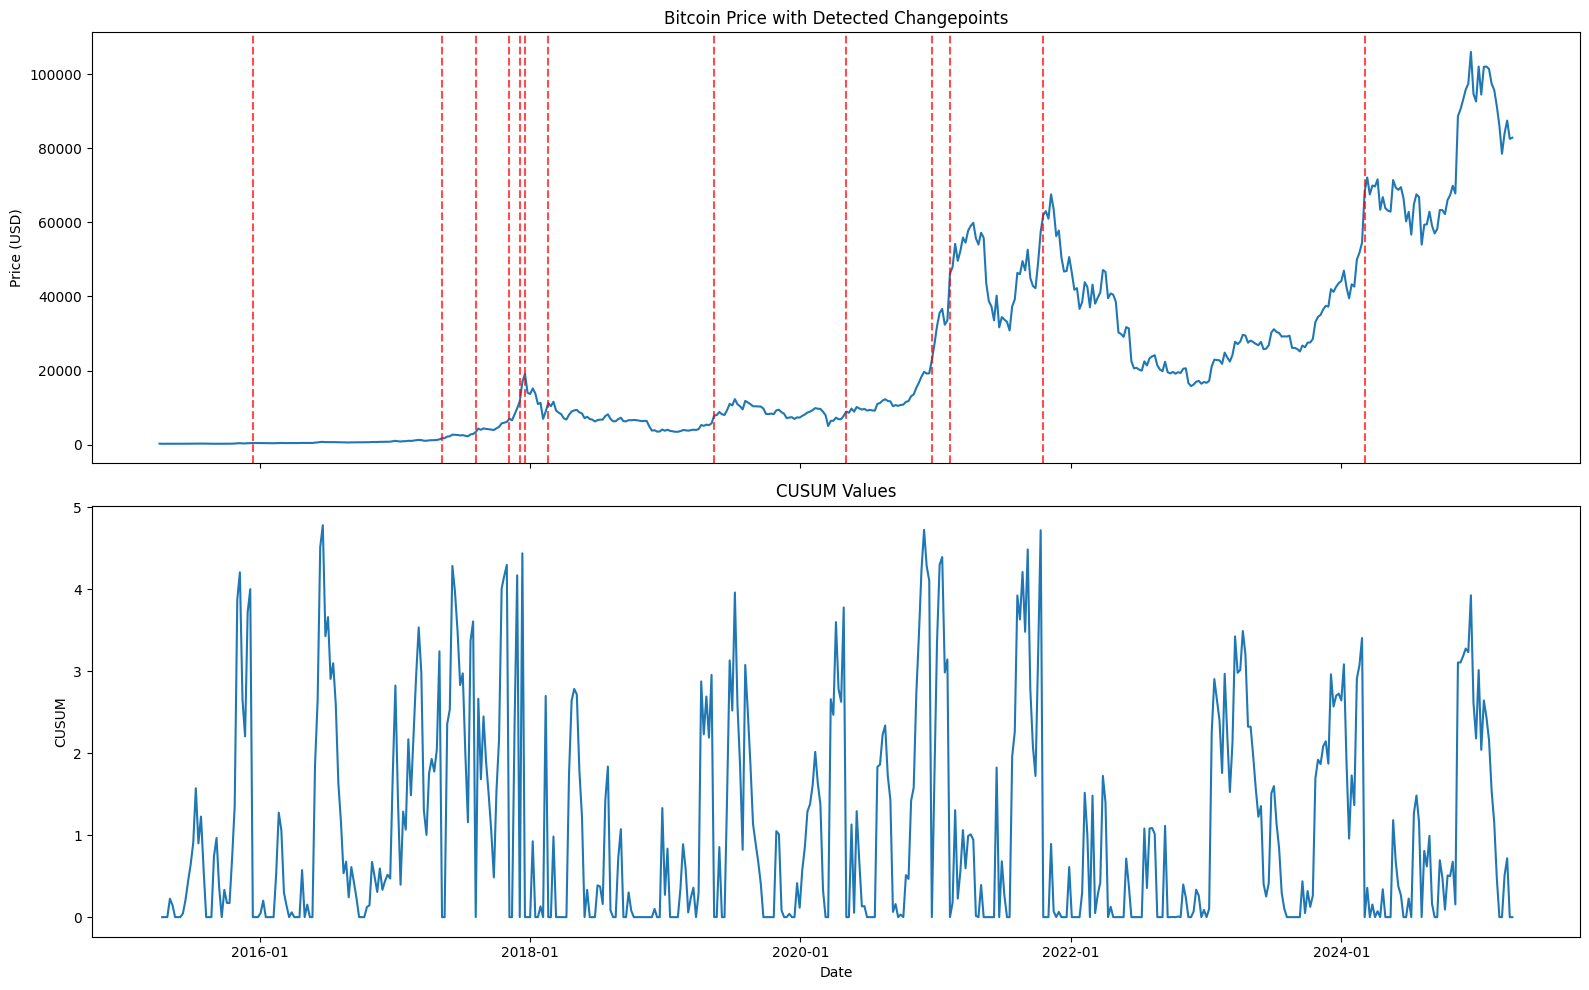

Detected 13 changepoints in Bitcoin price data:
1. 2015-12-14
2. 2017-05-08
3. 2017-08-07
4. 2017-11-06
5. 2017-12-04
6. 2017-12-18
7. 2018-02-19
8. 2019-05-13
9. 2020-05-04
10. 2020-12-21
11. 2021-02-08
12. 2021-10-18
13. 2024-03-04

Price behavior around changepoints:

Changepoint: 2015-12-14
Price 4 weeks before: $330.75
Price 4 weeks after: $448.43
Percentage change: 35.58%

Changepoint: 2017-05-08
Price 4 weeks before: $1187.13
Price 4 weeks after: $2686.81
Percentage change: 126.33%

Changepoint: 2017-08-07
Price 4 weeks before: $2372.56
Price 4 weeks after: $4236.31
Percentage change: 78.55%

Changepoint: 2017-11-06
Price 4 weeks before: $4772.02
Price 4 weeks after: $11657.20
Percentage change: 144.28%

Changepoint: 2017-12-04
Price 4 weeks before: $7022.76
Price 4 weeks after: $13657.20
Percentage change: 94.47%

Changepoint: 2017-12-18
Price 4 weeks before: $8200.64
Price 4 weeks after: $13819.80
Percentage change: 68.52%

Changepoint: 2018-02-19
Price 4 weeks before: $10931.

In [105]:
# Changepoint detection using CUSUM
from statsmodels.tsa.stattools import acf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from matplotlib.dates import DateFormatter

def detect_cusum_changepoints(series, threshold=1.0, drift=0.0, show_plot=True):
    """
    Detect changepoints using CUSUM (Cumulative Sum) method.

    Parameters:
    -----------
    series : pandas.Series
        Time series data with datetime index
    threshold : float
        Threshold for declaring a changepoint (higher = less sensitive)
    drift : float
        Allows for a small upward/downward trend
    show_plot : bool
        Whether to show the plot of CUSUM and changepoints

    Returns:
    --------
    list
        Dates of detected changepoints
    """
    # 📌 Convert DataFrame to Series if needed
    if isinstance(series, pd.DataFrame):
        series = series.iloc[:, 0]  # Select first column if DataFrame

    # Calculate returns (percentage changes)
    returns = series.pct_change().dropna()

    # Standardize returns
    std_returns = (returns - returns.mean()) / returns.std()

    # Initialize CUSUM values
    cusums = np.zeros(len(std_returns))
    changepoints = []

    # Calculate CUSUM values
    for i in range(1, len(std_returns)):
        cusums[i] = max(0, cusums[i-1] + std_returns.iloc[i] - drift)

        # Check if value exceeds threshold
        if cusums[i] > threshold:
            changepoints.append(std_returns.index[i])
            cusums[i] = 0  # Reset CUSUM after detecting a changepoint

    if show_plot:
        fig, (ax1, ax2) = plt.subplots(2, 1, figsize=(16, 10), sharex=True)

        # Plot original series
        ax1.plot(series)
        for cp in changepoints:
            ax1.axvline(x=cp, color='r', linestyle='--', alpha=0.7)
        ax1.set_title('Bitcoin Price with Detected Changepoints')
        ax1.set_ylabel('Price (USD)')

        # Plot CUSUM values
        cusum_series = pd.Series(cusums, index=std_returns.index)
        ax2.plot(cusum_series)
        ax2.set_title('CUSUM Values')
        ax2.set_ylabel('CUSUM')
        ax2.set_xlabel('Date')

        # Format date axis
        date_form = DateFormatter("%Y-%m")
        ax2.xaxis.set_major_formatter(date_form)

        plt.tight_layout()
        plt.show()

    return changepoints

# Run CUSUM changepoint detection on btc_weekly
changepoints = detect_cusum_changepoints(btc_weekly, threshold=5, drift=0.05)

# Print detected changepoints
print(f"Detected {len(changepoints)} changepoints in Bitcoin price data:")
for i, cp in enumerate(changepoints, 1):
    print(f"{i}. {cp.strftime('%Y-%m-%d')}")

# Analyze price changes around changepoints
if len(changepoints) > 0:
    window_size = 4  # Weeks to analyze before and after changepoint

    print("\nPrice behavior around changepoints:")
    for cp in changepoints:
        # Get data around changepoint
        start_date = cp - pd.Timedelta(weeks=window_size)
        end_date = cp + pd.Timedelta(weeks=window_size)

        cp_window = btc_weekly.loc[start_date:end_date]

        # Calculate percentage change
        pre_cp = btc_weekly.loc[start_date:cp].iloc[0,0]
        post_cp = btc_weekly.loc[cp:end_date].iloc[-1,0]
        pct_change = ((post_cp - pre_cp) / pre_cp) * 100

        print(f"\nChangepoint: {cp.strftime('%Y-%m-%d')}")
        print(f"Price {window_size} weeks before: ${pre_cp:.2f}")
        print(f"Price {window_size} weeks after: ${post_cp:.2f}")
        print(f"Percentage change: {pct_change:.2f}%")

shewhart_control_chart

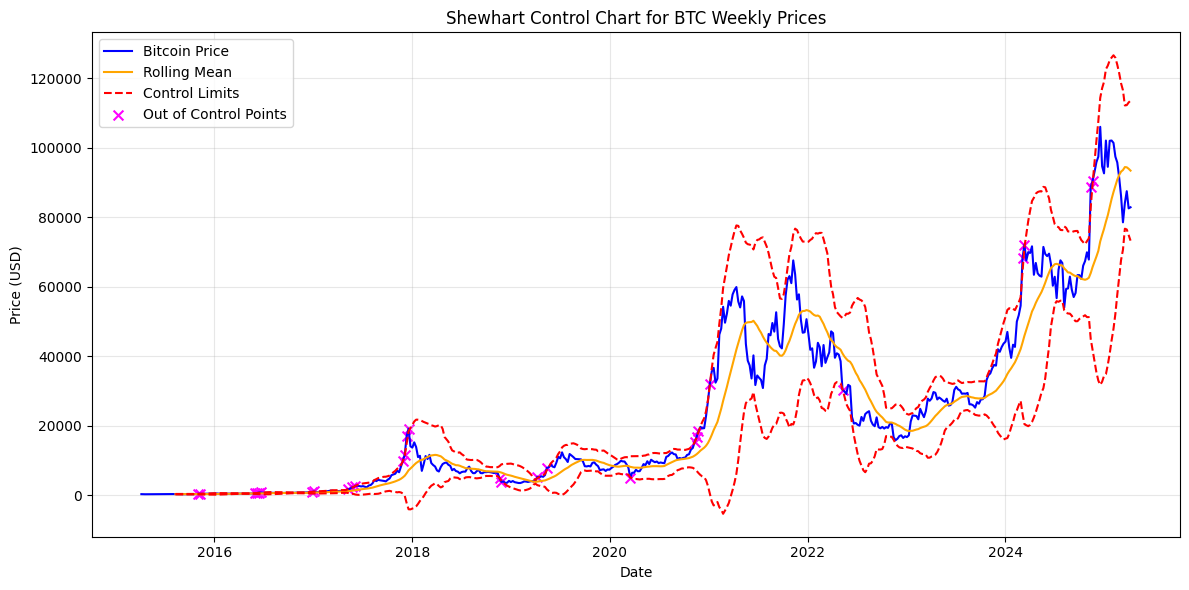

🔍 Out-of-Control Dates Detected by Shewhart Chart:
1. 2015-11-02
2. 2015-11-09
3. 2016-05-30
4. 2016-06-06
5. 2016-06-13
6. 2016-06-20
7. 2016-12-26
8. 2017-01-02
9. 2017-05-08
10. 2017-05-22
11. 2017-06-05
12. 2017-11-27
13. 2017-12-04
14. 2017-12-11
15. 2017-12-18
16. 2018-11-19
17. 2018-11-26
18. 2019-04-08
19. 2019-05-13
20. 2020-03-16
21. 2020-11-09
22. 2020-11-16
23. 2020-11-23
24. 2021-01-04
25. 2022-05-09
26. 2024-03-04
27. 2024-03-11
28. 2024-11-11
29. 2024-11-18


In [104]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

def shewhart_control_chart(series, window_size=16, num_std=3):
    """
    Implements a simple Shewhart control chart.
    Flags points beyond ±num_std * rolling std from the rolling mean.
    """
    roll_mean = series.rolling(window_size).mean()
    roll_std = series.rolling(window_size).std()

    upper_limit = roll_mean + num_std * roll_std
    lower_limit = roll_mean - num_std * roll_std
    out_of_control = (series > upper_limit) | (series < lower_limit)

    results = pd.DataFrame({
        'mean': roll_mean,
        'upper_limit': upper_limit,
        'lower_limit': lower_limit,
        'out_of_control': out_of_control
    }, index=series.index)

    return results

# Apply the control chart
results_shewhart = shewhart_control_chart(btc_weekly['bitcoin_price'], window_size=19, num_std=2.55)

# Plot
plt.figure(figsize=(12, 6))
plt.plot(btc_weekly.index, btc_weekly['bitcoin_price'], label='Bitcoin Price', color='blue')
plt.plot(results_shewhart.index, results_shewhart['mean'], color='orange', label='Rolling Mean')
plt.plot(results_shewhart.index, results_shewhart['upper_limit'], color='red', linestyle='--', label='Control Limits')
plt.plot(results_shewhart.index, results_shewhart['lower_limit'], color='red', linestyle='--')
plt.scatter(results_shewhart.index[results_shewhart['out_of_control']],
            btc_weekly[results_shewhart['out_of_control']],
            color='magenta', marker='x', s=50, label='Out of Control Points')
plt.title("Shewhart Control Chart for BTC Weekly Prices")
plt.xlabel("Date")
plt.ylabel("Price (USD)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Print dates of out-of-control points
outlier_dates = results_shewhart.index[results_shewhart['out_of_control']].strftime('%Y-%m-%d').tolist()

print("🔍 Out-of-Control Dates Detected by Shewhart Chart:")
for i, date in enumerate(outlier_dates, 1):
    print(f"{i}. {date}")


In [219]:
!jupyter nbconvert --to html /content/Project_205736879_302342498.ipynb

[NbConvertApp] WARNING | pattern '/content/Project_205736879_302342498.ipynb' matched no files
This application is used to convert notebook files (*.ipynb)
        to various other formats.


Options
The options below are convenience aliases to configurable class-options,
as listed in the "Equivalent to" description-line of the aliases.
To see all configurable class-options for some <cmd>, use:
    <cmd> --help-all

--debug
    set log level to logging.DEBUG (maximize logging output)
    Equivalent to: [--Application.log_level=10]
--show-config
    Show the application's configuration (human-readable format)
    Equivalent to: [--Application.show_config=True]
--show-config-json
    Show the application's configuration (json format)
    Equivalent to: [--Application.show_config_json=True]
--generate-config
    generate default config file
    Equivalent to: [--JupyterApp.generate_config=True]
-y
    Answer yes to any questions instead of prompting.
    Equivalent to: [--JupyterApp.answe